In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import gc
import math

In [2]:
#Params
input_size=750
batch_size=512
nbr_epochs=600
data_split_ratio=0.8
chunksize = 100000
lr = 0.000075
y_column = "300s"
files_x = ["data/x_Swedbank_A_750_p.csv",]
files_y = ["data/y_Swedbank_A_750.csv",]

In [3]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    dev_data_x = torch.tensor(xs[t:].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:].values, dtype=torch.float32)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y)

In [4]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [5]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [6]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1000).type(dtype)
        nn.init.normal(self.fc1.weight, mean=0, std=1)
        self.fc1.weight = nn.Parameter(self.fc1.weight * math.sqrt(2/input_size))
        self.fc2 = nn.Linear(1000, 2000).type(dtype)
        nn.init.normal(self.fc2.weight, mean=0, std=1)
        self.fc2.weight = nn.Parameter(self.fc2.weight * math.sqrt(2/input_size))
        self.fc3 = nn.Linear(2000, 1000).type(dtype)
        nn.init.normal(self.fc3.weight, mean=0, std=1)
        self.fc3.weight = nn.Parameter(self.fc3.weight * math.sqrt(2/input_size))
        self.fc4 = nn.Linear(1000, 500).type(dtype)
        nn.init.normal(self.fc4.weight, mean=0, std=1)
        self.fc4.weight = nn.Parameter(self.fc4.weight * math.sqrt(2/input_size))
        self.fc5 = nn.Linear(500, 100).type(dtype)
        nn.init.normal(self.fc5.weight, mean=0, std=1)
        self.fc5.weight = nn.Parameter(self.fc5.weight * math.sqrt(2/input_size))
        self.fc6 = nn.Linear(100, 20).type(dtype)
        nn.init.normal(self.fc6.weight, mean=0, std=1)
        self.fc6.weight = nn.Parameter(self.fc6.weight * math.sqrt(2/input_size))
        self.fc7 = nn.Linear(20, 1).type(dtype)
        nn.init.normal(self.fc7.weight, mean=0, std=1)
        self.fc7.weight = nn.Parameter(self.fc7.weight * math.sqrt(2/input_size))
        
        self.drop_layer = nn.Dropout(p=0.010)
    
    def forward(self, x):
        #print(x)
        fc1 = self.fc1(x)
        x = F.relu(fc1)
        #x = self.drop_layer(x)
        #print(fc1)
        #print(x)
        x = F.relu(self.fc2(x))
        #x = self.drop_layer(x)
        #print(x)
        x = F.relu(self.fc3(x))
        #x = self.drop_layer(x)
        #x = self.drop_layer(x)
        #print(x)
        x= F.relu(self.fc4(x))
        #print(y)
        x = F.relu(self.fc5(x))
        #x = self.drop_layer(x)
        x = F.relu(self.fc6(x))
        y = F.relu(self.fc7(x))
        return y

In [7]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [8]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            
            pred = model(x)

            loss = loss_fn(pred, y)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [9]:
def train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size):
    train_data, dev_data = splitData(x_data, y_data, data_split_ratio)
    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)
    

In [10]:
#Start training
model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = model.to(device)
test_data_x = pd.DataFrame()
test_data_y = pd.DataFrame()
for i in range(len(files_x)):
    print("Current file: " + files_x[i])
    total_rows = sum(1 for row in open(files_x[i], 'r'))
    number_of_loops = int(total_rows/chunksize)
    print("Number of chunks: " + str(number_of_loops))
    current_loop = 0
    with pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)], chunksize=chunksize) as reader_x,\
    pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int}, chunksize=chunksize) as reader_y:
        for chunk_x, chunk_y in zip(reader_x, reader_y):
            print("Progress: " + "{:.2f}".format(100 * current_loop/number_of_loops) + "%")
            x_data = chunk_x
            y_data = chunk_y
            if(current_loop < data_split_ratio * number_of_loops):
                y_data = y_data[y_column]
                train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size)
            else:
                print("Append test data")
                test_data_x = test_data_x.append(x_data)
                test_data_y = test_data_y.append(y_data)
            current_loop+=1

test_data_x = torch.tensor(test_data_x.values, dtype=torch.float32)
test_data_y = torch.tensor(test_data_y[y_column].values, dtype=torch.float32)
test_data = TensorDataset(test_data_x, test_data_y)
#test_data_y = test_data_y[y_column]
#test_data = list(zip(test_data_x, test_data_y))
#for i in range(len(files_x)):
#    x_data = pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)])
#    y_data = pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int})
#    y_data = y_data[y_column]
#    print(x_data.shape)
#    print(y_data.shape)
#    x_data.head()
#    y_data.head()
#    print(files_x[i])
#    train_data, dev_data, test_data = splitData(x_data, y_data, data_split_ratio)
#    train_data_loader = DataLoader(train_data, batch_size=batch_size)
#    dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
#    model = model.to(device)
#    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)
#    del [[x_data, y_data, train_data, dev_data, train_data_loader, dev_data_loader]]
#    gc.collect()



/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # This is added back by InteractiveShellApp.init_path()
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.normal is now deprecated i

Current file: data/x_Swedbank_A_750_p.csv
Number of chunks: 31


/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 0.00%


/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Epoch 0 	Loss: 151.839 	Loss (val): 5.037
Epoch 1 	Loss: 0.628 	Loss (val): 3.847
Epoch 2 	Loss: 0.441 	Loss (val): 3.257
Epoch 3 	Loss: 0.610 	Loss (val): 0.379
Epoch 4 	Loss: 0.446 	Loss (val): 1.154
Epoch 5 	Loss: 0.392 	Loss (val): 3.549
Epoch 6 	Loss: 0.348 	Loss (val): 1.143
Epoch 7 	Loss: 0.363 	Loss (val): 0.922
Epoch 8 	Loss: 0.418 	Loss (val): 2.948
Epoch 9 	Loss: 0.424 	Loss (val): 9.160
Epoch 10 	Loss: 0.604 	Loss (val): 12.166
Epoch 11 	Loss: 0.906 	Loss (val): 14.203
Epoch 12 	Loss: 1.090 	Loss (val): 9.013
Epoch 13 	Loss: 1.064 	Loss (val): 5.277
Epoch 14 	Loss: 0.959 	Loss (val): 3.956
Epoch 15 	Loss: 0.981 	Loss (val): 2.599
Epoch 16 	Loss: 1.069 	Loss (val): 3.997
Epoch 17 	Loss: 1.040 	Loss (val): 3.593
Epoch 18 	Loss: 1.047 	Loss (val): 3.319
Epoch 19 	Loss: 1.022 	Loss (val): 3.529
Epoch 20 	Loss: 1.039 	Loss (val): 3.714
Epoch 21 	Loss: 0.956 	Loss (val): 4.150
Epoch 22 	Loss: 1.127 	Loss (val): 3.236
Epoch 23 	Loss: 1.015 	Loss (val): 1.507
Epoch 24 	Loss: 0.872 

Epoch 198 	Loss: 0.350 	Loss (val): 0.932
Epoch 199 	Loss: 0.347 	Loss (val): 0.944
Epoch 200 	Loss: 0.345 	Loss (val): 0.958
Epoch 201 	Loss: 0.343 	Loss (val): 0.950
Epoch 202 	Loss: 0.347 	Loss (val): 0.980
Epoch 203 	Loss: 0.343 	Loss (val): 0.997
Epoch 204 	Loss: 0.341 	Loss (val): 1.014
Epoch 205 	Loss: 0.345 	Loss (val): 1.015
Epoch 206 	Loss: 0.340 	Loss (val): 1.058
Epoch 207 	Loss: 0.337 	Loss (val): 1.015
Epoch 208 	Loss: 0.344 	Loss (val): 0.863
Epoch 209 	Loss: 0.342 	Loss (val): 1.081
Epoch 210 	Loss: 0.347 	Loss (val): 1.127
Epoch 211 	Loss: 0.339 	Loss (val): 1.083
Epoch 212 	Loss: 0.337 	Loss (val): 1.190
Epoch 213 	Loss: 0.325 	Loss (val): 0.902
Epoch 214 	Loss: 0.344 	Loss (val): 1.107
Epoch 215 	Loss: 0.339 	Loss (val): 1.191
Epoch 216 	Loss: 0.336 	Loss (val): 1.245
Epoch 217 	Loss: 0.320 	Loss (val): 1.084
Epoch 218 	Loss: 0.344 	Loss (val): 1.215
Epoch 219 	Loss: 0.346 	Loss (val): 1.323
Epoch 220 	Loss: 0.336 	Loss (val): 1.293
Epoch 221 	Loss: 0.336 	Loss (val)

Epoch 394 	Loss: 0.482 	Loss (val): 3.859
Epoch 395 	Loss: 0.477 	Loss (val): 3.847
Epoch 396 	Loss: 0.477 	Loss (val): 3.841
Epoch 397 	Loss: 0.476 	Loss (val): 3.832
Epoch 398 	Loss: 0.475 	Loss (val): 3.838
Epoch 399 	Loss: 0.475 	Loss (val): 3.866
Epoch 400 	Loss: 0.474 	Loss (val): 3.816
Epoch 401 	Loss: 0.475 	Loss (val): 3.798
Epoch 402 	Loss: 0.472 	Loss (val): 3.790
Epoch 403 	Loss: 0.473 	Loss (val): 3.784
Epoch 404 	Loss: 0.471 	Loss (val): 3.779
Epoch 405 	Loss: 0.471 	Loss (val): 3.801
Epoch 406 	Loss: 0.471 	Loss (val): 3.820
Epoch 407 	Loss: 0.480 	Loss (val): 3.889
Epoch 408 	Loss: 0.472 	Loss (val): 3.823
Epoch 409 	Loss: 0.472 	Loss (val): 3.791
Epoch 410 	Loss: 0.469 	Loss (val): 3.770
Epoch 411 	Loss: 0.470 	Loss (val): 3.744
Epoch 412 	Loss: 0.467 	Loss (val): 3.750
Epoch 413 	Loss: 0.478 	Loss (val): 3.759
Epoch 414 	Loss: 0.482 	Loss (val): 3.717
Epoch 415 	Loss: 0.464 	Loss (val): 3.706
Epoch 416 	Loss: 0.463 	Loss (val): 3.702
Epoch 417 	Loss: 0.463 	Loss (val)

Epoch 590 	Loss: 0.420 	Loss (val): 2.452
Epoch 591 	Loss: 0.420 	Loss (val): 2.461
Epoch 592 	Loss: 0.420 	Loss (val): 2.445
Epoch 593 	Loss: 0.422 	Loss (val): 2.455
Epoch 594 	Loss: 0.421 	Loss (val): 2.442
Epoch 595 	Loss: 0.421 	Loss (val): 2.435
Epoch 596 	Loss: 0.423 	Loss (val): 2.432
Epoch 597 	Loss: 0.418 	Loss (val): 2.437
Epoch 598 	Loss: 0.421 	Loss (val): 2.430
Epoch 599 	Loss: 0.421 	Loss (val): 2.432
Progress: 3.23%
Epoch 0 	Loss: 0.353 	Loss (val): 0.175
Epoch 1 	Loss: 0.383 	Loss (val): 0.173
Epoch 2 	Loss: 0.380 	Loss (val): 0.171
Epoch 3 	Loss: 0.377 	Loss (val): 0.170
Epoch 4 	Loss: 0.373 	Loss (val): 0.171
Epoch 5 	Loss: 0.370 	Loss (val): 0.172
Epoch 6 	Loss: 0.367 	Loss (val): 0.174
Epoch 7 	Loss: 0.363 	Loss (val): 0.177
Epoch 8 	Loss: 0.360 	Loss (val): 0.180
Epoch 9 	Loss: 0.356 	Loss (val): 0.185
Epoch 10 	Loss: 0.333 	Loss (val): 0.271
Epoch 11 	Loss: 0.356 	Loss (val): 0.258
Epoch 12 	Loss: 0.342 	Loss (val): 0.249
Epoch 13 	Loss: 0.342 	Loss (val): 0.246


Epoch 188 	Loss: 0.384 	Loss (val): 0.261
Epoch 189 	Loss: 0.383 	Loss (val): 0.262
Epoch 190 	Loss: 0.383 	Loss (val): 0.262
Epoch 191 	Loss: 0.383 	Loss (val): 0.254
Epoch 192 	Loss: 0.383 	Loss (val): 0.262
Epoch 193 	Loss: 0.382 	Loss (val): 0.262
Epoch 194 	Loss: 0.381 	Loss (val): 0.262
Epoch 195 	Loss: 0.381 	Loss (val): 0.262
Epoch 196 	Loss: 0.382 	Loss (val): 0.259
Epoch 197 	Loss: 0.381 	Loss (val): 0.262
Epoch 198 	Loss: 0.381 	Loss (val): 0.262
Epoch 199 	Loss: 0.381 	Loss (val): 0.262
Epoch 200 	Loss: 0.372 	Loss (val): 0.264
Epoch 201 	Loss: 0.382 	Loss (val): 0.260
Epoch 202 	Loss: 0.382 	Loss (val): 0.263
Epoch 203 	Loss: 0.380 	Loss (val): 0.263
Epoch 204 	Loss: 0.380 	Loss (val): 0.263
Epoch 205 	Loss: 0.379 	Loss (val): 0.263
Epoch 206 	Loss: 0.380 	Loss (val): 0.263
Epoch 207 	Loss: 0.379 	Loss (val): 0.261
Epoch 208 	Loss: 0.379 	Loss (val): 0.263
Epoch 209 	Loss: 0.379 	Loss (val): 0.263
Epoch 210 	Loss: 0.379 	Loss (val): 0.257
Epoch 211 	Loss: 0.379 	Loss (val)

Epoch 384 	Loss: 0.348 	Loss (val): 0.283
Epoch 385 	Loss: 0.353 	Loss (val): 0.286
Epoch 386 	Loss: 0.352 	Loss (val): 0.286
Epoch 387 	Loss: 0.350 	Loss (val): 0.285
Epoch 388 	Loss: 0.352 	Loss (val): 0.287
Epoch 389 	Loss: 0.351 	Loss (val): 0.286
Epoch 390 	Loss: 0.350 	Loss (val): 0.287
Epoch 391 	Loss: 0.350 	Loss (val): 0.287
Epoch 392 	Loss: 0.351 	Loss (val): 0.288
Epoch 393 	Loss: 0.350 	Loss (val): 0.280
Epoch 394 	Loss: 0.352 	Loss (val): 0.287
Epoch 395 	Loss: 0.351 	Loss (val): 0.288
Epoch 396 	Loss: 0.350 	Loss (val): 0.288
Epoch 397 	Loss: 0.350 	Loss (val): 0.289
Epoch 398 	Loss: 0.348 	Loss (val): 0.289
Epoch 399 	Loss: 0.350 	Loss (val): 0.289
Epoch 400 	Loss: 0.350 	Loss (val): 0.289
Epoch 401 	Loss: 0.349 	Loss (val): 0.289
Epoch 402 	Loss: 0.349 	Loss (val): 0.289
Epoch 403 	Loss: 0.349 	Loss (val): 0.290
Epoch 404 	Loss: 0.349 	Loss (val): 0.290
Epoch 405 	Loss: 0.349 	Loss (val): 0.290
Epoch 406 	Loss: 0.349 	Loss (val): 0.290
Epoch 407 	Loss: 0.349 	Loss (val)

Epoch 580 	Loss: 0.342 	Loss (val): 0.296
Epoch 581 	Loss: 0.342 	Loss (val): 0.296
Epoch 582 	Loss: 0.342 	Loss (val): 0.271
Epoch 583 	Loss: 0.341 	Loss (val): 0.298
Epoch 584 	Loss: 0.342 	Loss (val): 0.296
Epoch 585 	Loss: 0.342 	Loss (val): 0.296
Epoch 586 	Loss: 0.343 	Loss (val): 0.295
Epoch 587 	Loss: 0.343 	Loss (val): 0.295
Epoch 588 	Loss: 0.335 	Loss (val): 0.298
Epoch 589 	Loss: 0.342 	Loss (val): 0.297
Epoch 590 	Loss: 0.342 	Loss (val): 0.296
Epoch 591 	Loss: 0.342 	Loss (val): 0.295
Epoch 592 	Loss: 0.343 	Loss (val): 0.295
Epoch 593 	Loss: 0.343 	Loss (val): 0.294
Epoch 594 	Loss: 0.343 	Loss (val): 0.293
Epoch 595 	Loss: 0.343 	Loss (val): 0.293
Epoch 596 	Loss: 0.343 	Loss (val): 0.292
Epoch 597 	Loss: 0.344 	Loss (val): 0.291
Epoch 598 	Loss: 0.344 	Loss (val): 0.291
Epoch 599 	Loss: 0.341 	Loss (val): 0.300
Progress: 6.45%
Epoch 0 	Loss: 0.655 	Loss (val): 0.327
Epoch 1 	Loss: 0.588 	Loss (val): 0.247
Epoch 2 	Loss: 0.656 	Loss (val): 0.135
Epoch 3 	Loss: 0.770 	Lo

Epoch 178 	Loss: 0.604 	Loss (val): 0.732
Epoch 179 	Loss: 0.604 	Loss (val): 0.731
Epoch 180 	Loss: 0.603 	Loss (val): 0.733
Epoch 181 	Loss: 0.603 	Loss (val): 0.731
Epoch 182 	Loss: 0.603 	Loss (val): 0.731
Epoch 183 	Loss: 0.602 	Loss (val): 0.731
Epoch 184 	Loss: 0.602 	Loss (val): 0.731
Epoch 185 	Loss: 0.602 	Loss (val): 0.727
Epoch 186 	Loss: 0.604 	Loss (val): 0.729
Epoch 187 	Loss: 0.601 	Loss (val): 0.729
Epoch 188 	Loss: 0.614 	Loss (val): 0.755
Epoch 189 	Loss: 0.614 	Loss (val): 0.736
Epoch 190 	Loss: 0.602 	Loss (val): 0.727
Epoch 191 	Loss: 0.599 	Loss (val): 0.728
Epoch 192 	Loss: 0.599 	Loss (val): 0.727
Epoch 193 	Loss: 0.615 	Loss (val): 0.731
Epoch 194 	Loss: 0.600 	Loss (val): 0.727
Epoch 195 	Loss: 0.598 	Loss (val): 0.726
Epoch 196 	Loss: 0.605 	Loss (val): 0.723
Epoch 197 	Loss: 0.601 	Loss (val): 0.737
Epoch 198 	Loss: 0.599 	Loss (val): 0.724
Epoch 199 	Loss: 0.602 	Loss (val): 0.724
Epoch 200 	Loss: 0.591 	Loss (val): 0.713
Epoch 201 	Loss: 0.596 	Loss (val)

Epoch 374 	Loss: 0.546 	Loss (val): 0.668
Epoch 375 	Loss: 0.544 	Loss (val): 0.668
Epoch 376 	Loss: 0.544 	Loss (val): 0.667
Epoch 377 	Loss: 0.589 	Loss (val): 0.693
Epoch 378 	Loss: 0.560 	Loss (val): 0.677
Epoch 379 	Loss: 0.550 	Loss (val): 0.671
Epoch 380 	Loss: 0.546 	Loss (val): 0.669
Epoch 381 	Loss: 0.546 	Loss (val): 0.668
Epoch 382 	Loss: 0.544 	Loss (val): 0.673
Epoch 383 	Loss: 0.556 	Loss (val): 0.667
Epoch 384 	Loss: 0.546 	Loss (val): 0.665
Epoch 385 	Loss: 0.540 	Loss (val): 0.608
Epoch 386 	Loss: 0.610 	Loss (val): 0.684
Epoch 387 	Loss: 0.557 	Loss (val): 0.674
Epoch 388 	Loss: 0.544 	Loss (val): 0.665
Epoch 389 	Loss: 0.542 	Loss (val): 0.665
Epoch 390 	Loss: 0.542 	Loss (val): 0.665
Epoch 391 	Loss: 0.543 	Loss (val): 0.665
Epoch 392 	Loss: 0.543 	Loss (val): 0.666
Epoch 393 	Loss: 0.560 	Loss (val): 0.675
Epoch 394 	Loss: 0.551 	Loss (val): 0.666
Epoch 395 	Loss: 0.543 	Loss (val): 0.665
Epoch 396 	Loss: 0.543 	Loss (val): 0.664
Epoch 397 	Loss: 0.542 	Loss (val)

Epoch 570 	Loss: 0.491 	Loss (val): 0.595
Epoch 571 	Loss: 0.490 	Loss (val): 0.594
Epoch 572 	Loss: 0.489 	Loss (val): 0.593
Epoch 573 	Loss: 0.496 	Loss (val): 0.595
Epoch 574 	Loss: 0.489 	Loss (val): 0.591
Epoch 575 	Loss: 0.487 	Loss (val): 0.591
Epoch 576 	Loss: 0.488 	Loss (val): 0.591
Epoch 577 	Loss: 0.487 	Loss (val): 0.590
Epoch 578 	Loss: 0.487 	Loss (val): 0.589
Epoch 579 	Loss: 0.487 	Loss (val): 0.590
Epoch 580 	Loss: 0.487 	Loss (val): 0.591
Epoch 581 	Loss: 0.487 	Loss (val): 0.589
Epoch 582 	Loss: 0.487 	Loss (val): 0.588
Epoch 583 	Loss: 0.485 	Loss (val): 0.588
Epoch 584 	Loss: 0.485 	Loss (val): 0.587
Epoch 585 	Loss: 0.485 	Loss (val): 0.587
Epoch 586 	Loss: 0.485 	Loss (val): 0.586
Epoch 587 	Loss: 0.484 	Loss (val): 0.586
Epoch 588 	Loss: 0.484 	Loss (val): 0.570
Epoch 589 	Loss: 0.501 	Loss (val): 0.582
Epoch 590 	Loss: 0.486 	Loss (val): 0.582
Epoch 591 	Loss: 0.481 	Loss (val): 0.581
Epoch 592 	Loss: 0.481 	Loss (val): 0.580
Epoch 593 	Loss: 0.481 	Loss (val)

Epoch 168 	Loss: 0.353 	Loss (val): 0.654
Epoch 169 	Loss: 0.352 	Loss (val): 0.652
Epoch 170 	Loss: 0.352 	Loss (val): 0.651
Epoch 171 	Loss: 0.352 	Loss (val): 0.651
Epoch 172 	Loss: 0.352 	Loss (val): 0.650
Epoch 173 	Loss: 0.354 	Loss (val): 0.652
Epoch 174 	Loss: 0.353 	Loss (val): 0.654
Epoch 175 	Loss: 0.352 	Loss (val): 0.649
Epoch 176 	Loss: 0.351 	Loss (val): 0.648
Epoch 177 	Loss: 0.353 	Loss (val): 0.648
Epoch 178 	Loss: 0.351 	Loss (val): 0.647
Epoch 179 	Loss: 0.351 	Loss (val): 0.647
Epoch 180 	Loss: 0.351 	Loss (val): 0.647
Epoch 181 	Loss: 0.350 	Loss (val): 0.646
Epoch 182 	Loss: 0.351 	Loss (val): 0.646
Epoch 183 	Loss: 0.350 	Loss (val): 0.645
Epoch 184 	Loss: 0.350 	Loss (val): 0.645
Epoch 185 	Loss: 0.350 	Loss (val): 0.644
Epoch 186 	Loss: 0.350 	Loss (val): 0.644
Epoch 187 	Loss: 0.350 	Loss (val): 0.644
Epoch 188 	Loss: 0.349 	Loss (val): 0.643
Epoch 189 	Loss: 0.349 	Loss (val): 0.643
Epoch 190 	Loss: 0.356 	Loss (val): 0.662
Epoch 191 	Loss: 0.353 	Loss (val)

Epoch 364 	Loss: 0.333 	Loss (val): 0.592
Epoch 365 	Loss: 0.333 	Loss (val): 0.592
Epoch 366 	Loss: 0.333 	Loss (val): 0.591
Epoch 367 	Loss: 0.334 	Loss (val): 0.609
Epoch 368 	Loss: 0.336 	Loss (val): 0.597
Epoch 369 	Loss: 0.334 	Loss (val): 0.594
Epoch 370 	Loss: 0.333 	Loss (val): 0.592
Epoch 371 	Loss: 0.332 	Loss (val): 0.591
Epoch 372 	Loss: 0.332 	Loss (val): 0.590
Epoch 373 	Loss: 0.332 	Loss (val): 0.590
Epoch 374 	Loss: 0.332 	Loss (val): 0.590
Epoch 375 	Loss: 0.332 	Loss (val): 0.589
Epoch 376 	Loss: 0.332 	Loss (val): 0.589
Epoch 377 	Loss: 0.332 	Loss (val): 0.589
Epoch 378 	Loss: 0.331 	Loss (val): 0.589
Epoch 379 	Loss: 0.332 	Loss (val): 0.588
Epoch 380 	Loss: 0.331 	Loss (val): 0.588
Epoch 381 	Loss: 0.331 	Loss (val): 0.588
Epoch 382 	Loss: 0.331 	Loss (val): 0.587
Epoch 383 	Loss: 0.331 	Loss (val): 0.587
Epoch 384 	Loss: 0.331 	Loss (val): 0.586
Epoch 385 	Loss: 0.331 	Loss (val): 0.586
Epoch 386 	Loss: 0.331 	Loss (val): 0.586
Epoch 387 	Loss: 0.330 	Loss (val)

Epoch 560 	Loss: 0.315 	Loss (val): 0.542
Epoch 561 	Loss: 0.315 	Loss (val): 0.535
Epoch 562 	Loss: 0.315 	Loss (val): 0.535
Epoch 563 	Loss: 0.314 	Loss (val): 0.535
Epoch 564 	Loss: 0.314 	Loss (val): 0.535
Epoch 565 	Loss: 0.314 	Loss (val): 0.534
Epoch 566 	Loss: 0.314 	Loss (val): 0.534
Epoch 567 	Loss: 0.314 	Loss (val): 0.534
Epoch 568 	Loss: 0.314 	Loss (val): 0.543
Epoch 569 	Loss: 0.318 	Loss (val): 0.557
Epoch 570 	Loss: 0.318 	Loss (val): 0.538
Epoch 571 	Loss: 0.315 	Loss (val): 0.535
Epoch 572 	Loss: 0.314 	Loss (val): 0.534
Epoch 573 	Loss: 0.314 	Loss (val): 0.534
Epoch 574 	Loss: 0.314 	Loss (val): 0.533
Epoch 575 	Loss: 0.314 	Loss (val): 0.533
Epoch 576 	Loss: 0.314 	Loss (val): 0.533
Epoch 577 	Loss: 0.314 	Loss (val): 0.545
Epoch 578 	Loss: 0.316 	Loss (val): 0.537
Epoch 579 	Loss: 0.314 	Loss (val): 0.535
Epoch 580 	Loss: 0.314 	Loss (val): 0.533
Epoch 581 	Loss: 0.314 	Loss (val): 0.533
Epoch 582 	Loss: 0.314 	Loss (val): 0.532
Epoch 583 	Loss: 0.313 	Loss (val)

Epoch 158 	Loss: 0.453 	Loss (val): 0.177
Epoch 159 	Loss: 0.456 	Loss (val): 0.178
Epoch 160 	Loss: 0.455 	Loss (val): 0.178
Epoch 161 	Loss: 0.456 	Loss (val): 0.178
Epoch 162 	Loss: 0.455 	Loss (val): 0.178
Epoch 163 	Loss: 0.455 	Loss (val): 0.178
Epoch 164 	Loss: 0.457 	Loss (val): 0.177
Epoch 165 	Loss: 0.476 	Loss (val): 0.178
Epoch 166 	Loss: 0.466 	Loss (val): 0.178
Epoch 167 	Loss: 0.460 	Loss (val): 0.178
Epoch 168 	Loss: 0.458 	Loss (val): 0.178
Epoch 169 	Loss: 0.457 	Loss (val): 0.178
Epoch 170 	Loss: 0.456 	Loss (val): 0.178
Epoch 171 	Loss: 0.456 	Loss (val): 0.177
Epoch 172 	Loss: 0.453 	Loss (val): 0.177
Epoch 173 	Loss: 0.472 	Loss (val): 0.178
Epoch 174 	Loss: 0.461 	Loss (val): 0.178
Epoch 175 	Loss: 0.459 	Loss (val): 0.178
Epoch 176 	Loss: 0.458 	Loss (val): 0.178
Epoch 177 	Loss: 0.457 	Loss (val): 0.178
Epoch 178 	Loss: 0.457 	Loss (val): 0.178
Epoch 179 	Loss: 0.457 	Loss (val): 0.178
Epoch 180 	Loss: 0.457 	Loss (val): 0.178
Epoch 181 	Loss: 0.456 	Loss (val)

Epoch 354 	Loss: 0.439 	Loss (val): 0.174
Epoch 355 	Loss: 0.439 	Loss (val): 0.174
Epoch 356 	Loss: 0.439 	Loss (val): 0.174
Epoch 357 	Loss: 0.439 	Loss (val): 0.174
Epoch 358 	Loss: 0.439 	Loss (val): 0.174
Epoch 359 	Loss: 0.439 	Loss (val): 0.174
Epoch 360 	Loss: 0.442 	Loss (val): 0.174
Epoch 361 	Loss: 0.438 	Loss (val): 0.173
Epoch 362 	Loss: 0.438 	Loss (val): 0.173
Epoch 363 	Loss: 0.438 	Loss (val): 0.173
Epoch 364 	Loss: 0.438 	Loss (val): 0.173
Epoch 365 	Loss: 0.438 	Loss (val): 0.173
Epoch 366 	Loss: 0.436 	Loss (val): 0.173
Epoch 367 	Loss: 0.438 	Loss (val): 0.173
Epoch 368 	Loss: 0.438 	Loss (val): 0.173
Epoch 369 	Loss: 0.439 	Loss (val): 0.173
Epoch 370 	Loss: 0.437 	Loss (val): 0.173
Epoch 371 	Loss: 0.437 	Loss (val): 0.173
Epoch 372 	Loss: 0.437 	Loss (val): 0.173
Epoch 373 	Loss: 0.437 	Loss (val): 0.173
Epoch 374 	Loss: 0.437 	Loss (val): 0.173
Epoch 375 	Loss: 0.437 	Loss (val): 0.173
Epoch 376 	Loss: 0.437 	Loss (val): 0.173
Epoch 377 	Loss: 0.437 	Loss (val)

Epoch 550 	Loss: 0.423 	Loss (val): 0.168
Epoch 551 	Loss: 0.422 	Loss (val): 0.168
Epoch 552 	Loss: 0.422 	Loss (val): 0.168
Epoch 553 	Loss: 0.422 	Loss (val): 0.168
Epoch 554 	Loss: 0.422 	Loss (val): 0.168
Epoch 555 	Loss: 0.422 	Loss (val): 0.167
Epoch 556 	Loss: 0.422 	Loss (val): 0.167
Epoch 557 	Loss: 0.422 	Loss (val): 0.167
Epoch 558 	Loss: 0.422 	Loss (val): 0.167
Epoch 559 	Loss: 0.422 	Loss (val): 0.167
Epoch 560 	Loss: 0.422 	Loss (val): 0.167
Epoch 561 	Loss: 0.422 	Loss (val): 0.167
Epoch 562 	Loss: 0.422 	Loss (val): 0.167
Epoch 563 	Loss: 0.421 	Loss (val): 0.167
Epoch 564 	Loss: 0.421 	Loss (val): 0.167
Epoch 565 	Loss: 0.421 	Loss (val): 0.167
Epoch 566 	Loss: 0.421 	Loss (val): 0.167
Epoch 567 	Loss: 0.421 	Loss (val): 0.167
Epoch 568 	Loss: 0.421 	Loss (val): 0.167
Epoch 569 	Loss: 0.423 	Loss (val): 0.169
Epoch 570 	Loss: 0.424 	Loss (val): 0.168
Epoch 571 	Loss: 0.422 	Loss (val): 0.167
Epoch 572 	Loss: 0.421 	Loss (val): 0.167
Epoch 573 	Loss: 0.421 	Loss (val)

Epoch 148 	Loss: 0.702 	Loss (val): 1.330
Epoch 149 	Loss: 0.702 	Loss (val): 1.330
Epoch 150 	Loss: 0.701 	Loss (val): 1.330
Epoch 151 	Loss: 0.702 	Loss (val): 1.331
Epoch 152 	Loss: 0.701 	Loss (val): 1.331
Epoch 153 	Loss: 0.701 	Loss (val): 1.331
Epoch 154 	Loss: 0.701 	Loss (val): 1.331
Epoch 155 	Loss: 0.701 	Loss (val): 1.331
Epoch 156 	Loss: 0.700 	Loss (val): 1.331
Epoch 157 	Loss: 0.701 	Loss (val): 1.332
Epoch 158 	Loss: 0.701 	Loss (val): 1.332
Epoch 159 	Loss: 0.700 	Loss (val): 1.332
Epoch 160 	Loss: 0.700 	Loss (val): 1.332
Epoch 161 	Loss: 0.700 	Loss (val): 1.332
Epoch 162 	Loss: 0.700 	Loss (val): 1.332
Epoch 163 	Loss: 0.700 	Loss (val): 1.332
Epoch 164 	Loss: 0.700 	Loss (val): 1.332
Epoch 165 	Loss: 0.698 	Loss (val): 1.332
Epoch 166 	Loss: 0.700 	Loss (val): 1.332
Epoch 167 	Loss: 0.700 	Loss (val): 1.332
Epoch 168 	Loss: 0.700 	Loss (val): 1.332
Epoch 169 	Loss: 0.699 	Loss (val): 1.332
Epoch 170 	Loss: 0.699 	Loss (val): 1.333
Epoch 171 	Loss: 0.699 	Loss (val)

Epoch 344 	Loss: 0.675 	Loss (val): 1.326
Epoch 345 	Loss: 0.675 	Loss (val): 1.327
Epoch 346 	Loss: 0.678 	Loss (val): 1.326
Epoch 347 	Loss: 0.677 	Loss (val): 1.326
Epoch 348 	Loss: 0.677 	Loss (val): 1.326
Epoch 349 	Loss: 0.677 	Loss (val): 1.326
Epoch 350 	Loss: 0.677 	Loss (val): 1.326
Epoch 351 	Loss: 0.676 	Loss (val): 1.326
Epoch 352 	Loss: 0.676 	Loss (val): 1.326
Epoch 353 	Loss: 0.676 	Loss (val): 1.326
Epoch 354 	Loss: 0.676 	Loss (val): 1.326
Epoch 355 	Loss: 0.676 	Loss (val): 1.326
Epoch 356 	Loss: 0.675 	Loss (val): 1.326
Epoch 357 	Loss: 0.676 	Loss (val): 1.326
Epoch 358 	Loss: 0.676 	Loss (val): 1.325
Epoch 359 	Loss: 0.675 	Loss (val): 1.325
Epoch 360 	Loss: 0.675 	Loss (val): 1.325
Epoch 361 	Loss: 0.675 	Loss (val): 1.325
Epoch 362 	Loss: 0.675 	Loss (val): 1.325
Epoch 363 	Loss: 0.675 	Loss (val): 1.325
Epoch 364 	Loss: 0.675 	Loss (val): 1.325
Epoch 365 	Loss: 0.675 	Loss (val): 1.325
Epoch 366 	Loss: 0.670 	Loss (val): 1.321
Epoch 367 	Loss: 0.678 	Loss (val)

Epoch 540 	Loss: 0.652 	Loss (val): 1.297
Epoch 541 	Loss: 0.648 	Loss (val): 1.292
Epoch 542 	Loss: 0.666 	Loss (val): 1.296
Epoch 543 	Loss: 0.658 	Loss (val): 1.297
Epoch 544 	Loss: 0.656 	Loss (val): 1.297
Epoch 545 	Loss: 0.653 	Loss (val): 1.296
Epoch 546 	Loss: 0.654 	Loss (val): 1.296
Epoch 547 	Loss: 0.653 	Loss (val): 1.296
Epoch 548 	Loss: 0.653 	Loss (val): 1.296
Epoch 549 	Loss: 0.653 	Loss (val): 1.296
Epoch 550 	Loss: 0.652 	Loss (val): 1.291
Epoch 551 	Loss: 0.654 	Loss (val): 1.296
Epoch 552 	Loss: 0.652 	Loss (val): 1.295
Epoch 553 	Loss: 0.651 	Loss (val): 1.295
Epoch 554 	Loss: 0.651 	Loss (val): 1.295
Epoch 555 	Loss: 0.651 	Loss (val): 1.295
Epoch 556 	Loss: 0.651 	Loss (val): 1.295
Epoch 557 	Loss: 0.651 	Loss (val): 1.295
Epoch 558 	Loss: 0.651 	Loss (val): 1.295
Epoch 559 	Loss: 0.650 	Loss (val): 1.294
Epoch 560 	Loss: 0.650 	Loss (val): 1.294
Epoch 561 	Loss: 0.650 	Loss (val): 1.294
Epoch 562 	Loss: 0.650 	Loss (val): 1.294
Epoch 563 	Loss: 0.650 	Loss (val)

Epoch 138 	Loss: 0.411 	Loss (val): 0.379
Epoch 139 	Loss: 0.411 	Loss (val): 0.379
Epoch 140 	Loss: 0.410 	Loss (val): 0.379
Epoch 141 	Loss: 0.410 	Loss (val): 0.378
Epoch 142 	Loss: 0.411 	Loss (val): 0.378
Epoch 143 	Loss: 0.410 	Loss (val): 0.378
Epoch 144 	Loss: 0.410 	Loss (val): 0.378
Epoch 145 	Loss: 0.410 	Loss (val): 0.377
Epoch 146 	Loss: 0.410 	Loss (val): 0.377
Epoch 147 	Loss: 0.410 	Loss (val): 0.377
Epoch 148 	Loss: 0.410 	Loss (val): 0.377
Epoch 149 	Loss: 0.410 	Loss (val): 0.376
Epoch 150 	Loss: 0.409 	Loss (val): 0.376
Epoch 151 	Loss: 0.410 	Loss (val): 0.376
Epoch 152 	Loss: 0.409 	Loss (val): 0.375
Epoch 153 	Loss: 0.409 	Loss (val): 0.383
Epoch 154 	Loss: 0.411 	Loss (val): 0.376
Epoch 155 	Loss: 0.409 	Loss (val): 0.375
Epoch 156 	Loss: 0.409 	Loss (val): 0.375
Epoch 157 	Loss: 0.409 	Loss (val): 0.374
Epoch 158 	Loss: 0.409 	Loss (val): 0.374
Epoch 159 	Loss: 0.409 	Loss (val): 0.374
Epoch 160 	Loss: 0.409 	Loss (val): 0.373
Epoch 161 	Loss: 0.408 	Loss (val)

Epoch 334 	Loss: 0.395 	Loss (val): 0.338
Epoch 335 	Loss: 0.395 	Loss (val): 0.344
Epoch 336 	Loss: 0.396 	Loss (val): 0.337
Epoch 337 	Loss: 0.395 	Loss (val): 0.337
Epoch 338 	Loss: 0.395 	Loss (val): 0.337
Epoch 339 	Loss: 0.395 	Loss (val): 0.337
Epoch 340 	Loss: 0.395 	Loss (val): 0.337
Epoch 341 	Loss: 0.395 	Loss (val): 0.336
Epoch 342 	Loss: 0.395 	Loss (val): 0.336
Epoch 343 	Loss: 0.394 	Loss (val): 0.336
Epoch 344 	Loss: 0.394 	Loss (val): 0.336
Epoch 345 	Loss: 0.394 	Loss (val): 0.336
Epoch 346 	Loss: 0.394 	Loss (val): 0.336
Epoch 347 	Loss: 0.394 	Loss (val): 0.336
Epoch 348 	Loss: 0.394 	Loss (val): 0.335
Epoch 349 	Loss: 0.394 	Loss (val): 0.335
Epoch 350 	Loss: 0.394 	Loss (val): 0.335
Epoch 351 	Loss: 0.394 	Loss (val): 0.335
Epoch 352 	Loss: 0.394 	Loss (val): 0.336
Epoch 353 	Loss: 0.394 	Loss (val): 0.335
Epoch 354 	Loss: 0.394 	Loss (val): 0.335
Epoch 355 	Loss: 0.394 	Loss (val): 0.334
Epoch 356 	Loss: 0.394 	Loss (val): 0.334
Epoch 357 	Loss: 0.394 	Loss (val)

Epoch 530 	Loss: 0.388 	Loss (val): 0.314
Epoch 531 	Loss: 0.388 	Loss (val): 0.314
Epoch 532 	Loss: 0.388 	Loss (val): 0.314
Epoch 533 	Loss: 0.388 	Loss (val): 0.314
Epoch 534 	Loss: 0.388 	Loss (val): 0.313
Epoch 535 	Loss: 0.388 	Loss (val): 0.319
Epoch 536 	Loss: 0.388 	Loss (val): 0.313
Epoch 537 	Loss: 0.387 	Loss (val): 0.312
Epoch 538 	Loss: 0.391 	Loss (val): 0.463
Epoch 539 	Loss: 0.434 	Loss (val): 0.363
Epoch 540 	Loss: 0.405 	Loss (val): 0.335
Epoch 541 	Loss: 0.396 	Loss (val): 0.325
Epoch 542 	Loss: 0.392 	Loss (val): 0.321
Epoch 543 	Loss: 0.391 	Loss (val): 0.334
Epoch 544 	Loss: 0.393 	Loss (val): 0.319
Epoch 545 	Loss: 0.390 	Loss (val): 0.317
Epoch 546 	Loss: 0.389 	Loss (val): 0.316
Epoch 547 	Loss: 0.389 	Loss (val): 0.316
Epoch 548 	Loss: 0.389 	Loss (val): 0.315
Epoch 549 	Loss: 0.389 	Loss (val): 0.315
Epoch 550 	Loss: 0.389 	Loss (val): 0.315
Epoch 551 	Loss: 0.389 	Loss (val): 0.315
Epoch 552 	Loss: 0.388 	Loss (val): 0.314
Epoch 553 	Loss: 0.388 	Loss (val)

Epoch 128 	Loss: 0.289 	Loss (val): 0.848
Epoch 129 	Loss: 0.289 	Loss (val): 0.848
Epoch 130 	Loss: 0.289 	Loss (val): 0.848
Epoch 131 	Loss: 0.289 	Loss (val): 0.848
Epoch 132 	Loss: 0.289 	Loss (val): 0.849
Epoch 133 	Loss: 0.288 	Loss (val): 0.849
Epoch 134 	Loss: 0.289 	Loss (val): 0.849
Epoch 135 	Loss: 0.289 	Loss (val): 0.849
Epoch 136 	Loss: 0.288 	Loss (val): 0.850
Epoch 137 	Loss: 0.288 	Loss (val): 0.850
Epoch 138 	Loss: 0.288 	Loss (val): 0.850
Epoch 139 	Loss: 0.288 	Loss (val): 0.850
Epoch 140 	Loss: 0.288 	Loss (val): 0.850
Epoch 141 	Loss: 0.288 	Loss (val): 0.851
Epoch 142 	Loss: 0.288 	Loss (val): 0.851
Epoch 143 	Loss: 0.288 	Loss (val): 0.851
Epoch 144 	Loss: 0.288 	Loss (val): 0.850
Epoch 145 	Loss: 0.288 	Loss (val): 0.851
Epoch 146 	Loss: 0.288 	Loss (val): 0.852
Epoch 147 	Loss: 0.288 	Loss (val): 0.852
Epoch 148 	Loss: 0.295 	Loss (val): 0.840
Epoch 149 	Loss: 0.288 	Loss (val): 0.852
Epoch 150 	Loss: 0.285 	Loss (val): 0.828
Epoch 151 	Loss: 0.290 	Loss (val)

Epoch 324 	Loss: 0.283 	Loss (val): 0.892
Epoch 325 	Loss: 0.283 	Loss (val): 0.892
Epoch 326 	Loss: 0.284 	Loss (val): 0.893
Epoch 327 	Loss: 0.283 	Loss (val): 0.893
Epoch 328 	Loss: 0.283 	Loss (val): 0.893
Epoch 329 	Loss: 0.283 	Loss (val): 0.894
Epoch 330 	Loss: 0.283 	Loss (val): 0.894
Epoch 331 	Loss: 0.283 	Loss (val): 0.894
Epoch 332 	Loss: 0.283 	Loss (val): 0.894
Epoch 333 	Loss: 0.283 	Loss (val): 0.894
Epoch 334 	Loss: 0.283 	Loss (val): 0.894
Epoch 335 	Loss: 0.283 	Loss (val): 0.895
Epoch 336 	Loss: 0.283 	Loss (val): 0.895
Epoch 337 	Loss: 0.294 	Loss (val): 0.860
Epoch 338 	Loss: 0.285 	Loss (val): 0.884
Epoch 339 	Loss: 0.284 	Loss (val): 0.889
Epoch 340 	Loss: 0.284 	Loss (val): 0.891
Epoch 341 	Loss: 0.283 	Loss (val): 0.892
Epoch 342 	Loss: 0.283 	Loss (val): 0.892
Epoch 343 	Loss: 0.285 	Loss (val): 0.879
Epoch 344 	Loss: 0.283 	Loss (val): 0.892
Epoch 345 	Loss: 0.283 	Loss (val): 0.893
Epoch 346 	Loss: 0.283 	Loss (val): 0.894
Epoch 347 	Loss: 0.283 	Loss (val)

Epoch 520 	Loss: 0.280 	Loss (val): 0.929
Epoch 521 	Loss: 0.280 	Loss (val): 0.929
Epoch 522 	Loss: 0.279 	Loss (val): 0.926
Epoch 523 	Loss: 0.280 	Loss (val): 0.929
Epoch 524 	Loss: 0.280 	Loss (val): 0.929
Epoch 525 	Loss: 0.280 	Loss (val): 0.930
Epoch 526 	Loss: 0.279 	Loss (val): 0.930
Epoch 527 	Loss: 0.279 	Loss (val): 0.930
Epoch 528 	Loss: 0.281 	Loss (val): 0.930
Epoch 529 	Loss: 0.279 	Loss (val): 0.932
Epoch 530 	Loss: 0.279 	Loss (val): 0.932
Epoch 531 	Loss: 0.279 	Loss (val): 0.932
Epoch 532 	Loss: 0.279 	Loss (val): 0.932
Epoch 533 	Loss: 0.279 	Loss (val): 0.932
Epoch 534 	Loss: 0.279 	Loss (val): 0.932
Epoch 535 	Loss: 0.279 	Loss (val): 0.932
Epoch 536 	Loss: 0.279 	Loss (val): 0.932
Epoch 537 	Loss: 0.279 	Loss (val): 0.932
Epoch 538 	Loss: 0.279 	Loss (val): 0.933
Epoch 539 	Loss: 0.279 	Loss (val): 0.933
Epoch 540 	Loss: 0.279 	Loss (val): 0.933
Epoch 541 	Loss: 0.279 	Loss (val): 0.933
Epoch 542 	Loss: 0.279 	Loss (val): 0.933
Epoch 543 	Loss: 0.279 	Loss (val)

Epoch 118 	Loss: 0.290 	Loss (val): 0.073
Epoch 119 	Loss: 0.290 	Loss (val): 0.073
Epoch 120 	Loss: 0.290 	Loss (val): 0.073
Epoch 121 	Loss: 0.290 	Loss (val): 0.073
Epoch 122 	Loss: 0.290 	Loss (val): 0.073
Epoch 123 	Loss: 0.290 	Loss (val): 0.073
Epoch 124 	Loss: 0.290 	Loss (val): 0.073
Epoch 125 	Loss: 0.290 	Loss (val): 0.073
Epoch 126 	Loss: 0.290 	Loss (val): 0.073
Epoch 127 	Loss: 0.290 	Loss (val): 0.072
Epoch 128 	Loss: 0.290 	Loss (val): 0.073
Epoch 129 	Loss: 0.290 	Loss (val): 0.073
Epoch 130 	Loss: 0.290 	Loss (val): 0.073
Epoch 131 	Loss: 0.290 	Loss (val): 0.073
Epoch 132 	Loss: 0.290 	Loss (val): 0.073
Epoch 133 	Loss: 0.289 	Loss (val): 0.073
Epoch 134 	Loss: 0.290 	Loss (val): 0.073
Epoch 135 	Loss: 0.290 	Loss (val): 0.073
Epoch 136 	Loss: 0.290 	Loss (val): 0.073
Epoch 137 	Loss: 0.290 	Loss (val): 0.073
Epoch 138 	Loss: 0.290 	Loss (val): 0.073
Epoch 139 	Loss: 0.290 	Loss (val): 0.073
Epoch 140 	Loss: 0.290 	Loss (val): 0.073
Epoch 141 	Loss: 0.290 	Loss (val)

Epoch 314 	Loss: 0.287 	Loss (val): 0.072
Epoch 315 	Loss: 0.287 	Loss (val): 0.072
Epoch 316 	Loss: 0.287 	Loss (val): 0.072
Epoch 317 	Loss: 0.287 	Loss (val): 0.072
Epoch 318 	Loss: 0.287 	Loss (val): 0.072
Epoch 319 	Loss: 0.287 	Loss (val): 0.072
Epoch 320 	Loss: 0.287 	Loss (val): 0.072
Epoch 321 	Loss: 0.287 	Loss (val): 0.072
Epoch 322 	Loss: 0.286 	Loss (val): 0.072
Epoch 323 	Loss: 0.286 	Loss (val): 0.072
Epoch 324 	Loss: 0.287 	Loss (val): 0.072
Epoch 325 	Loss: 0.287 	Loss (val): 0.072
Epoch 326 	Loss: 0.286 	Loss (val): 0.072
Epoch 327 	Loss: 0.286 	Loss (val): 0.072
Epoch 328 	Loss: 0.286 	Loss (val): 0.072
Epoch 329 	Loss: 0.286 	Loss (val): 0.072
Epoch 330 	Loss: 0.286 	Loss (val): 0.072
Epoch 331 	Loss: 0.286 	Loss (val): 0.072
Epoch 332 	Loss: 0.286 	Loss (val): 0.072
Epoch 333 	Loss: 0.286 	Loss (val): 0.072
Epoch 334 	Loss: 0.286 	Loss (val): 0.072
Epoch 335 	Loss: 0.286 	Loss (val): 0.072
Epoch 336 	Loss: 0.286 	Loss (val): 0.072
Epoch 337 	Loss: 0.286 	Loss (val)

Epoch 510 	Loss: 0.284 	Loss (val): 0.071
Epoch 511 	Loss: 0.284 	Loss (val): 0.071
Epoch 512 	Loss: 0.284 	Loss (val): 0.071
Epoch 513 	Loss: 0.284 	Loss (val): 0.071
Epoch 514 	Loss: 0.284 	Loss (val): 0.071
Epoch 515 	Loss: 0.284 	Loss (val): 0.071
Epoch 516 	Loss: 0.284 	Loss (val): 0.071
Epoch 517 	Loss: 0.284 	Loss (val): 0.071
Epoch 518 	Loss: 0.284 	Loss (val): 0.071
Epoch 519 	Loss: 0.284 	Loss (val): 0.071
Epoch 520 	Loss: 0.284 	Loss (val): 0.071
Epoch 521 	Loss: 0.284 	Loss (val): 0.071
Epoch 522 	Loss: 0.284 	Loss (val): 0.071
Epoch 523 	Loss: 0.284 	Loss (val): 0.071
Epoch 524 	Loss: 0.284 	Loss (val): 0.071
Epoch 525 	Loss: 0.284 	Loss (val): 0.071
Epoch 526 	Loss: 0.283 	Loss (val): 0.071
Epoch 527 	Loss: 0.284 	Loss (val): 0.071
Epoch 528 	Loss: 0.283 	Loss (val): 0.071
Epoch 529 	Loss: 0.284 	Loss (val): 0.071
Epoch 530 	Loss: 0.284 	Loss (val): 0.071
Epoch 531 	Loss: 0.284 	Loss (val): 0.071
Epoch 532 	Loss: 0.283 	Loss (val): 0.071
Epoch 533 	Loss: 0.284 	Loss (val)

Epoch 108 	Loss: 0.195 	Loss (val): 0.086
Epoch 109 	Loss: 0.196 	Loss (val): 0.087
Epoch 110 	Loss: 0.196 	Loss (val): 0.087
Epoch 111 	Loss: 0.195 	Loss (val): 0.086
Epoch 112 	Loss: 0.195 	Loss (val): 0.087
Epoch 113 	Loss: 0.196 	Loss (val): 0.087
Epoch 114 	Loss: 0.196 	Loss (val): 0.087
Epoch 115 	Loss: 0.195 	Loss (val): 0.087
Epoch 116 	Loss: 0.195 	Loss (val): 0.087
Epoch 117 	Loss: 0.196 	Loss (val): 0.087
Epoch 118 	Loss: 0.195 	Loss (val): 0.087
Epoch 119 	Loss: 0.195 	Loss (val): 0.087
Epoch 120 	Loss: 0.195 	Loss (val): 0.087
Epoch 121 	Loss: 0.196 	Loss (val): 0.087
Epoch 122 	Loss: 0.195 	Loss (val): 0.087
Epoch 123 	Loss: 0.196 	Loss (val): 0.087
Epoch 124 	Loss: 0.196 	Loss (val): 0.083
Epoch 125 	Loss: 0.196 	Loss (val): 0.087
Epoch 126 	Loss: 0.195 	Loss (val): 0.087
Epoch 127 	Loss: 0.195 	Loss (val): 0.087
Epoch 128 	Loss: 0.195 	Loss (val): 0.087
Epoch 129 	Loss: 0.195 	Loss (val): 0.088
Epoch 130 	Loss: 0.195 	Loss (val): 0.087
Epoch 131 	Loss: 0.195 	Loss (val)

Epoch 304 	Loss: 0.195 	Loss (val): 0.094
Epoch 305 	Loss: 0.195 	Loss (val): 0.094
Epoch 306 	Loss: 0.195 	Loss (val): 0.094
Epoch 307 	Loss: 0.195 	Loss (val): 0.094
Epoch 308 	Loss: 0.195 	Loss (val): 0.092
Epoch 309 	Loss: 0.196 	Loss (val): 0.093
Epoch 310 	Loss: 0.195 	Loss (val): 0.093
Epoch 311 	Loss: 0.195 	Loss (val): 0.094
Epoch 312 	Loss: 0.195 	Loss (val): 0.094
Epoch 313 	Loss: 0.195 	Loss (val): 0.094
Epoch 314 	Loss: 0.195 	Loss (val): 0.094
Epoch 315 	Loss: 0.195 	Loss (val): 0.094
Epoch 316 	Loss: 0.195 	Loss (val): 0.094
Epoch 317 	Loss: 0.195 	Loss (val): 0.094
Epoch 318 	Loss: 0.195 	Loss (val): 0.094
Epoch 319 	Loss: 0.195 	Loss (val): 0.095
Epoch 320 	Loss: 0.195 	Loss (val): 0.095
Epoch 321 	Loss: 0.195 	Loss (val): 0.095
Epoch 322 	Loss: 0.195 	Loss (val): 0.095
Epoch 323 	Loss: 0.195 	Loss (val): 0.095
Epoch 324 	Loss: 0.195 	Loss (val): 0.095
Epoch 325 	Loss: 0.195 	Loss (val): 0.095
Epoch 326 	Loss: 0.195 	Loss (val): 0.095
Epoch 327 	Loss: 0.195 	Loss (val)

Epoch 500 	Loss: 0.194 	Loss (val): 0.105
Epoch 501 	Loss: 0.194 	Loss (val): 0.105
Epoch 502 	Loss: 0.194 	Loss (val): 0.105
Epoch 503 	Loss: 0.194 	Loss (val): 0.105
Epoch 504 	Loss: 0.194 	Loss (val): 0.105
Epoch 505 	Loss: 0.194 	Loss (val): 0.105
Epoch 506 	Loss: 0.194 	Loss (val): 0.106
Epoch 507 	Loss: 0.194 	Loss (val): 0.106
Epoch 508 	Loss: 0.194 	Loss (val): 0.106
Epoch 509 	Loss: 0.195 	Loss (val): 0.102
Epoch 510 	Loss: 0.196 	Loss (val): 0.106
Epoch 511 	Loss: 0.194 	Loss (val): 0.106
Epoch 512 	Loss: 0.194 	Loss (val): 0.103
Epoch 513 	Loss: 0.195 	Loss (val): 0.105
Epoch 514 	Loss: 0.195 	Loss (val): 0.106
Epoch 515 	Loss: 0.194 	Loss (val): 0.106
Epoch 516 	Loss: 0.194 	Loss (val): 0.106
Epoch 517 	Loss: 0.194 	Loss (val): 0.106
Epoch 518 	Loss: 0.194 	Loss (val): 0.106
Epoch 519 	Loss: 0.194 	Loss (val): 0.106
Epoch 520 	Loss: 0.194 	Loss (val): 0.106
Epoch 521 	Loss: 0.194 	Loss (val): 0.106
Epoch 522 	Loss: 0.194 	Loss (val): 0.106
Epoch 523 	Loss: 0.194 	Loss (val)

Epoch 98 	Loss: 0.204 	Loss (val): 0.211
Epoch 99 	Loss: 0.204 	Loss (val): 0.211
Epoch 100 	Loss: 0.204 	Loss (val): 0.211
Epoch 101 	Loss: 0.204 	Loss (val): 0.210
Epoch 102 	Loss: 0.204 	Loss (val): 0.210
Epoch 103 	Loss: 0.204 	Loss (val): 0.210
Epoch 104 	Loss: 0.204 	Loss (val): 0.210
Epoch 105 	Loss: 0.204 	Loss (val): 0.210
Epoch 106 	Loss: 0.204 	Loss (val): 0.210
Epoch 107 	Loss: 0.204 	Loss (val): 0.210
Epoch 108 	Loss: 0.204 	Loss (val): 0.210
Epoch 109 	Loss: 0.208 	Loss (val): 0.229
Epoch 110 	Loss: 0.206 	Loss (val): 0.213
Epoch 111 	Loss: 0.205 	Loss (val): 0.211
Epoch 112 	Loss: 0.204 	Loss (val): 0.211
Epoch 113 	Loss: 0.204 	Loss (val): 0.210
Epoch 114 	Loss: 0.204 	Loss (val): 0.210
Epoch 115 	Loss: 0.204 	Loss (val): 0.210
Epoch 116 	Loss: 0.204 	Loss (val): 0.210
Epoch 117 	Loss: 0.204 	Loss (val): 0.210
Epoch 118 	Loss: 0.204 	Loss (val): 0.210
Epoch 119 	Loss: 0.204 	Loss (val): 0.210
Epoch 120 	Loss: 0.204 	Loss (val): 0.210
Epoch 121 	Loss: 0.211 	Loss (val): 

Epoch 294 	Loss: 0.201 	Loss (val): 0.205
Epoch 295 	Loss: 0.201 	Loss (val): 0.205
Epoch 296 	Loss: 0.201 	Loss (val): 0.205
Epoch 297 	Loss: 0.201 	Loss (val): 0.205
Epoch 298 	Loss: 0.201 	Loss (val): 0.205
Epoch 299 	Loss: 0.201 	Loss (val): 0.205
Epoch 300 	Loss: 0.201 	Loss (val): 0.205
Epoch 301 	Loss: 0.201 	Loss (val): 0.205
Epoch 302 	Loss: 0.201 	Loss (val): 0.205
Epoch 303 	Loss: 0.201 	Loss (val): 0.205
Epoch 304 	Loss: 0.201 	Loss (val): 0.205
Epoch 305 	Loss: 0.201 	Loss (val): 0.205
Epoch 306 	Loss: 0.202 	Loss (val): 0.208
Epoch 307 	Loss: 0.201 	Loss (val): 0.205
Epoch 308 	Loss: 0.201 	Loss (val): 0.205
Epoch 309 	Loss: 0.201 	Loss (val): 0.205
Epoch 310 	Loss: 0.201 	Loss (val): 0.205
Epoch 311 	Loss: 0.201 	Loss (val): 0.205
Epoch 312 	Loss: 0.201 	Loss (val): 0.205
Epoch 313 	Loss: 0.201 	Loss (val): 0.205
Epoch 314 	Loss: 0.201 	Loss (val): 0.205
Epoch 315 	Loss: 0.201 	Loss (val): 0.205
Epoch 316 	Loss: 0.201 	Loss (val): 0.205
Epoch 317 	Loss: 0.201 	Loss (val)

Epoch 490 	Loss: 0.198 	Loss (val): 0.201
Epoch 491 	Loss: 0.198 	Loss (val): 0.201
Epoch 492 	Loss: 0.198 	Loss (val): 0.201
Epoch 493 	Loss: 0.198 	Loss (val): 0.201
Epoch 494 	Loss: 0.198 	Loss (val): 0.201
Epoch 495 	Loss: 0.198 	Loss (val): 0.201
Epoch 496 	Loss: 0.198 	Loss (val): 0.201
Epoch 497 	Loss: 0.200 	Loss (val): 0.201
Epoch 498 	Loss: 0.198 	Loss (val): 0.201
Epoch 499 	Loss: 0.198 	Loss (val): 0.201
Epoch 500 	Loss: 0.198 	Loss (val): 0.201
Epoch 501 	Loss: 0.198 	Loss (val): 0.201
Epoch 502 	Loss: 0.198 	Loss (val): 0.201
Epoch 503 	Loss: 0.198 	Loss (val): 0.201
Epoch 504 	Loss: 0.198 	Loss (val): 0.201
Epoch 505 	Loss: 0.198 	Loss (val): 0.201
Epoch 506 	Loss: 0.198 	Loss (val): 0.200
Epoch 507 	Loss: 0.198 	Loss (val): 0.200
Epoch 508 	Loss: 0.198 	Loss (val): 0.200
Epoch 509 	Loss: 0.198 	Loss (val): 0.200
Epoch 510 	Loss: 0.198 	Loss (val): 0.200
Epoch 511 	Loss: 0.198 	Loss (val): 0.200
Epoch 512 	Loss: 0.198 	Loss (val): 0.200
Epoch 513 	Loss: 0.198 	Loss (val)

Epoch 87 	Loss: 0.783 	Loss (val): 0.383
Epoch 88 	Loss: 0.783 	Loss (val): 0.383
Epoch 89 	Loss: 0.783 	Loss (val): 0.382
Epoch 90 	Loss: 0.783 	Loss (val): 0.382
Epoch 91 	Loss: 0.783 	Loss (val): 0.382
Epoch 92 	Loss: 0.783 	Loss (val): 0.382
Epoch 93 	Loss: 0.782 	Loss (val): 0.443
Epoch 94 	Loss: 0.789 	Loss (val): 0.412
Epoch 95 	Loss: 0.786 	Loss (val): 0.404
Epoch 96 	Loss: 0.786 	Loss (val): 0.399
Epoch 97 	Loss: 0.787 	Loss (val): 0.432
Epoch 98 	Loss: 0.782 	Loss (val): 0.395
Epoch 99 	Loss: 0.784 	Loss (val): 0.393
Epoch 100 	Loss: 0.782 	Loss (val): 0.392
Epoch 101 	Loss: 0.784 	Loss (val): 0.391
Epoch 102 	Loss: 0.783 	Loss (val): 0.393
Epoch 103 	Loss: 0.783 	Loss (val): 0.390
Epoch 104 	Loss: 0.783 	Loss (val): 0.389
Epoch 105 	Loss: 0.784 	Loss (val): 0.428
Epoch 106 	Loss: 0.786 	Loss (val): 0.447
Epoch 107 	Loss: 0.785 	Loss (val): 0.398
Epoch 108 	Loss: 0.784 	Loss (val): 0.393
Epoch 109 	Loss: 0.783 	Loss (val): 0.390
Epoch 110 	Loss: 0.782 	Loss (val): 0.389
Epoch

Epoch 283 	Loss: 0.763 	Loss (val): 0.338
Epoch 284 	Loss: 0.764 	Loss (val): 0.339
Epoch 285 	Loss: 0.762 	Loss (val): 0.337
Epoch 286 	Loss: 0.762 	Loss (val): 0.336
Epoch 287 	Loss: 0.762 	Loss (val): 0.336
Epoch 288 	Loss: 0.762 	Loss (val): 0.335
Epoch 289 	Loss: 0.761 	Loss (val): 0.336
Epoch 290 	Loss: 0.762 	Loss (val): 0.334
Epoch 291 	Loss: 0.762 	Loss (val): 0.334
Epoch 292 	Loss: 0.761 	Loss (val): 0.334
Epoch 293 	Loss: 0.761 	Loss (val): 0.338
Epoch 294 	Loss: 0.760 	Loss (val): 0.333
Epoch 295 	Loss: 0.761 	Loss (val): 0.332
Epoch 296 	Loss: 0.761 	Loss (val): 0.332
Epoch 297 	Loss: 0.764 	Loss (val): 0.367
Epoch 298 	Loss: 0.761 	Loss (val): 0.331
Epoch 299 	Loss: 0.760 	Loss (val): 0.330
Epoch 300 	Loss: 0.760 	Loss (val): 0.329
Epoch 301 	Loss: 0.760 	Loss (val): 0.329
Epoch 302 	Loss: 0.760 	Loss (val): 0.329
Epoch 303 	Loss: 0.760 	Loss (val): 0.328
Epoch 304 	Loss: 0.760 	Loss (val): 0.328
Epoch 305 	Loss: 0.760 	Loss (val): 0.328
Epoch 306 	Loss: 0.760 	Loss (val)

Epoch 479 	Loss: 0.750 	Loss (val): 0.312
Epoch 480 	Loss: 0.750 	Loss (val): 0.312
Epoch 481 	Loss: 0.750 	Loss (val): 0.311
Epoch 482 	Loss: 0.750 	Loss (val): 0.311
Epoch 483 	Loss: 0.750 	Loss (val): 0.311
Epoch 484 	Loss: 0.750 	Loss (val): 0.311
Epoch 485 	Loss: 0.750 	Loss (val): 0.311
Epoch 486 	Loss: 0.750 	Loss (val): 0.311
Epoch 487 	Loss: 0.750 	Loss (val): 0.310
Epoch 488 	Loss: 0.750 	Loss (val): 0.310
Epoch 489 	Loss: 0.747 	Loss (val): 0.311
Epoch 490 	Loss: 0.750 	Loss (val): 0.310
Epoch 491 	Loss: 0.750 	Loss (val): 0.310
Epoch 492 	Loss: 0.750 	Loss (val): 0.310
Epoch 493 	Loss: 0.749 	Loss (val): 0.310
Epoch 494 	Loss: 0.749 	Loss (val): 0.310
Epoch 495 	Loss: 0.749 	Loss (val): 0.309
Epoch 496 	Loss: 0.749 	Loss (val): 0.309
Epoch 497 	Loss: 0.749 	Loss (val): 0.309
Epoch 498 	Loss: 0.749 	Loss (val): 0.309
Epoch 499 	Loss: 0.749 	Loss (val): 0.309
Epoch 500 	Loss: 0.748 	Loss (val): 0.309
Epoch 501 	Loss: 0.749 	Loss (val): 0.309
Epoch 502 	Loss: 0.749 	Loss (val)

Epoch 76 	Loss: 0.375 	Loss (val): 0.115
Epoch 77 	Loss: 0.374 	Loss (val): 0.115
Epoch 78 	Loss: 0.374 	Loss (val): 0.115
Epoch 79 	Loss: 0.374 	Loss (val): 0.115
Epoch 80 	Loss: 0.374 	Loss (val): 0.115
Epoch 81 	Loss: 0.375 	Loss (val): 0.115
Epoch 82 	Loss: 0.375 	Loss (val): 0.115
Epoch 83 	Loss: 0.374 	Loss (val): 0.115
Epoch 84 	Loss: 0.375 	Loss (val): 0.115
Epoch 85 	Loss: 0.373 	Loss (val): 0.115
Epoch 86 	Loss: 0.374 	Loss (val): 0.115
Epoch 87 	Loss: 0.375 	Loss (val): 0.115
Epoch 88 	Loss: 0.374 	Loss (val): 0.115
Epoch 89 	Loss: 0.374 	Loss (val): 0.115
Epoch 90 	Loss: 0.375 	Loss (val): 0.115
Epoch 91 	Loss: 0.374 	Loss (val): 0.115
Epoch 92 	Loss: 0.375 	Loss (val): 0.115
Epoch 93 	Loss: 0.374 	Loss (val): 0.115
Epoch 94 	Loss: 0.374 	Loss (val): 0.115
Epoch 95 	Loss: 0.374 	Loss (val): 0.115
Epoch 96 	Loss: 0.373 	Loss (val): 0.115
Epoch 97 	Loss: 0.374 	Loss (val): 0.115
Epoch 98 	Loss: 0.375 	Loss (val): 0.115
Epoch 99 	Loss: 0.374 	Loss (val): 0.115
Epoch 100 	Loss:

Epoch 272 	Loss: 0.375 	Loss (val): 0.115
Epoch 273 	Loss: 0.376 	Loss (val): 0.115
Epoch 274 	Loss: 0.376 	Loss (val): 0.115
Epoch 275 	Loss: 0.376 	Loss (val): 0.115
Epoch 276 	Loss: 0.376 	Loss (val): 0.115
Epoch 277 	Loss: 0.376 	Loss (val): 0.115
Epoch 278 	Loss: 0.376 	Loss (val): 0.115
Epoch 279 	Loss: 0.376 	Loss (val): 0.115
Epoch 280 	Loss: 0.376 	Loss (val): 0.115
Epoch 281 	Loss: 0.376 	Loss (val): 0.115
Epoch 282 	Loss: 0.376 	Loss (val): 0.115
Epoch 283 	Loss: 0.376 	Loss (val): 0.115
Epoch 284 	Loss: 0.376 	Loss (val): 0.115
Epoch 285 	Loss: 0.376 	Loss (val): 0.115
Epoch 286 	Loss: 0.375 	Loss (val): 0.115
Epoch 287 	Loss: 0.375 	Loss (val): 0.115
Epoch 288 	Loss: 0.376 	Loss (val): 0.115
Epoch 289 	Loss: 0.376 	Loss (val): 0.115
Epoch 290 	Loss: 0.376 	Loss (val): 0.115
Epoch 291 	Loss: 0.376 	Loss (val): 0.115
Epoch 292 	Loss: 0.376 	Loss (val): 0.115
Epoch 293 	Loss: 0.376 	Loss (val): 0.115
Epoch 294 	Loss: 0.376 	Loss (val): 0.115
Epoch 295 	Loss: 0.376 	Loss (val)

Epoch 468 	Loss: 0.377 	Loss (val): 0.116
Epoch 469 	Loss: 0.377 	Loss (val): 0.116
Epoch 470 	Loss: 0.377 	Loss (val): 0.116
Epoch 471 	Loss: 0.377 	Loss (val): 0.116
Epoch 472 	Loss: 0.377 	Loss (val): 0.116
Epoch 473 	Loss: 0.375 	Loss (val): 0.116
Epoch 474 	Loss: 0.378 	Loss (val): 0.116
Epoch 475 	Loss: 0.377 	Loss (val): 0.116
Epoch 476 	Loss: 0.377 	Loss (val): 0.116
Epoch 477 	Loss: 0.377 	Loss (val): 0.116
Epoch 478 	Loss: 0.377 	Loss (val): 0.116
Epoch 479 	Loss: 0.377 	Loss (val): 0.116
Epoch 480 	Loss: 0.377 	Loss (val): 0.116
Epoch 481 	Loss: 0.377 	Loss (val): 0.116
Epoch 482 	Loss: 0.377 	Loss (val): 0.116
Epoch 483 	Loss: 0.377 	Loss (val): 0.116
Epoch 484 	Loss: 0.377 	Loss (val): 0.116
Epoch 485 	Loss: 0.377 	Loss (val): 0.116
Epoch 486 	Loss: 0.378 	Loss (val): 0.116
Epoch 487 	Loss: 0.376 	Loss (val): 0.116
Epoch 488 	Loss: 0.378 	Loss (val): 0.116
Epoch 489 	Loss: 0.378 	Loss (val): 0.116
Epoch 490 	Loss: 0.378 	Loss (val): 0.116
Epoch 491 	Loss: 0.377 	Loss (val)

Epoch 65 	Loss: 0.444 	Loss (val): 0.136
Epoch 66 	Loss: 0.444 	Loss (val): 0.136
Epoch 67 	Loss: 0.444 	Loss (val): 0.136
Epoch 68 	Loss: 0.444 	Loss (val): 0.136
Epoch 69 	Loss: 0.444 	Loss (val): 0.136
Epoch 70 	Loss: 0.444 	Loss (val): 0.136
Epoch 71 	Loss: 0.444 	Loss (val): 0.136
Epoch 72 	Loss: 0.443 	Loss (val): 0.136
Epoch 73 	Loss: 0.444 	Loss (val): 0.136
Epoch 74 	Loss: 0.443 	Loss (val): 0.136
Epoch 75 	Loss: 0.443 	Loss (val): 0.136
Epoch 76 	Loss: 0.443 	Loss (val): 0.136
Epoch 77 	Loss: 0.444 	Loss (val): 0.136
Epoch 78 	Loss: 0.443 	Loss (val): 0.136
Epoch 79 	Loss: 0.443 	Loss (val): 0.136
Epoch 80 	Loss: 0.443 	Loss (val): 0.136
Epoch 81 	Loss: 0.443 	Loss (val): 0.136
Epoch 82 	Loss: 0.443 	Loss (val): 0.136
Epoch 83 	Loss: 0.443 	Loss (val): 0.136
Epoch 84 	Loss: 0.443 	Loss (val): 0.136
Epoch 85 	Loss: 0.443 	Loss (val): 0.136
Epoch 86 	Loss: 0.443 	Loss (val): 0.136
Epoch 87 	Loss: 0.445 	Loss (val): 0.136
Epoch 88 	Loss: 0.443 	Loss (val): 0.137
Epoch 89 	Loss: 

Epoch 261 	Loss: 0.440 	Loss (val): 0.143
Epoch 262 	Loss: 0.437 	Loss (val): 0.144
Epoch 263 	Loss: 0.437 	Loss (val): 0.144
Epoch 264 	Loss: 0.438 	Loss (val): 0.144
Epoch 265 	Loss: 0.438 	Loss (val): 0.144
Epoch 266 	Loss: 0.438 	Loss (val): 0.144
Epoch 267 	Loss: 0.437 	Loss (val): 0.144
Epoch 268 	Loss: 0.437 	Loss (val): 0.144
Epoch 269 	Loss: 0.438 	Loss (val): 0.144
Epoch 270 	Loss: 0.438 	Loss (val): 0.144
Epoch 271 	Loss: 0.437 	Loss (val): 0.144
Epoch 272 	Loss: 0.442 	Loss (val): 0.141
Epoch 273 	Loss: 0.437 	Loss (val): 0.143
Epoch 274 	Loss: 0.437 	Loss (val): 0.144
Epoch 275 	Loss: 0.439 	Loss (val): 0.144
Epoch 276 	Loss: 0.437 	Loss (val): 0.144
Epoch 277 	Loss: 0.437 	Loss (val): 0.144
Epoch 278 	Loss: 0.438 	Loss (val): 0.144
Epoch 279 	Loss: 0.437 	Loss (val): 0.144
Epoch 280 	Loss: 0.437 	Loss (val): 0.144
Epoch 281 	Loss: 0.437 	Loss (val): 0.144
Epoch 282 	Loss: 0.437 	Loss (val): 0.144
Epoch 283 	Loss: 0.437 	Loss (val): 0.144
Epoch 284 	Loss: 0.437 	Loss (val)

Epoch 457 	Loss: 0.432 	Loss (val): 0.149
Epoch 458 	Loss: 0.432 	Loss (val): 0.149
Epoch 459 	Loss: 0.432 	Loss (val): 0.150
Epoch 460 	Loss: 0.432 	Loss (val): 0.150
Epoch 461 	Loss: 0.431 	Loss (val): 0.150
Epoch 462 	Loss: 0.432 	Loss (val): 0.150
Epoch 463 	Loss: 0.431 	Loss (val): 0.150
Epoch 464 	Loss: 0.431 	Loss (val): 0.150
Epoch 465 	Loss: 0.431 	Loss (val): 0.150
Epoch 466 	Loss: 0.431 	Loss (val): 0.150
Epoch 467 	Loss: 0.431 	Loss (val): 0.150
Epoch 468 	Loss: 0.431 	Loss (val): 0.150
Epoch 469 	Loss: 0.432 	Loss (val): 0.150
Epoch 470 	Loss: 0.431 	Loss (val): 0.150
Epoch 471 	Loss: 0.431 	Loss (val): 0.150
Epoch 472 	Loss: 0.431 	Loss (val): 0.150
Epoch 473 	Loss: 0.431 	Loss (val): 0.150
Epoch 474 	Loss: 0.431 	Loss (val): 0.150
Epoch 475 	Loss: 0.431 	Loss (val): 0.150
Epoch 476 	Loss: 0.432 	Loss (val): 0.151
Epoch 477 	Loss: 0.430 	Loss (val): 0.151
Epoch 478 	Loss: 0.431 	Loss (val): 0.151
Epoch 479 	Loss: 0.430 	Loss (val): 0.150
Epoch 480 	Loss: 0.430 	Loss (val)

Epoch 54 	Loss: 0.718 	Loss (val): 0.636
Epoch 55 	Loss: 0.718 	Loss (val): 0.636
Epoch 56 	Loss: 0.718 	Loss (val): 0.636
Epoch 57 	Loss: 0.718 	Loss (val): 0.636
Epoch 58 	Loss: 0.718 	Loss (val): 0.636
Epoch 59 	Loss: 0.718 	Loss (val): 0.636
Epoch 60 	Loss: 0.718 	Loss (val): 0.636
Epoch 61 	Loss: 0.718 	Loss (val): 0.636
Epoch 62 	Loss: 0.718 	Loss (val): 0.636
Epoch 63 	Loss: 0.718 	Loss (val): 0.636
Epoch 64 	Loss: 0.718 	Loss (val): 0.636
Epoch 65 	Loss: 0.718 	Loss (val): 0.636
Epoch 66 	Loss: 0.718 	Loss (val): 0.636
Epoch 67 	Loss: 0.718 	Loss (val): 0.635
Epoch 68 	Loss: 0.718 	Loss (val): 0.635
Epoch 69 	Loss: 0.718 	Loss (val): 0.636
Epoch 70 	Loss: 0.718 	Loss (val): 0.636
Epoch 71 	Loss: 0.718 	Loss (val): 0.636
Epoch 72 	Loss: 0.718 	Loss (val): 0.636
Epoch 73 	Loss: 0.718 	Loss (val): 0.635
Epoch 74 	Loss: 0.718 	Loss (val): 0.636
Epoch 75 	Loss: 0.718 	Loss (val): 0.636
Epoch 76 	Loss: 0.718 	Loss (val): 0.636
Epoch 77 	Loss: 0.717 	Loss (val): 0.636
Epoch 78 	Loss: 

Epoch 251 	Loss: 0.704 	Loss (val): 0.637
Epoch 252 	Loss: 0.717 	Loss (val): 0.635
Epoch 253 	Loss: 0.714 	Loss (val): 0.635
Epoch 254 	Loss: 0.713 	Loss (val): 0.635
Epoch 255 	Loss: 0.712 	Loss (val): 0.635
Epoch 256 	Loss: 0.712 	Loss (val): 0.635
Epoch 257 	Loss: 0.712 	Loss (val): 0.638
Epoch 258 	Loss: 0.711 	Loss (val): 0.623
Epoch 259 	Loss: 0.711 	Loss (val): 0.635
Epoch 260 	Loss: 0.711 	Loss (val): 0.635
Epoch 261 	Loss: 0.711 	Loss (val): 0.634
Epoch 262 	Loss: 0.712 	Loss (val): 0.643
Epoch 263 	Loss: 0.711 	Loss (val): 0.635
Epoch 264 	Loss: 0.710 	Loss (val): 0.635
Epoch 265 	Loss: 0.710 	Loss (val): 0.635
Epoch 266 	Loss: 0.710 	Loss (val): 0.635
Epoch 267 	Loss: 0.710 	Loss (val): 0.635
Epoch 268 	Loss: 0.710 	Loss (val): 0.635
Epoch 269 	Loss: 0.711 	Loss (val): 0.635
Epoch 270 	Loss: 0.710 	Loss (val): 0.635
Epoch 271 	Loss: 0.710 	Loss (val): 0.635
Epoch 272 	Loss: 0.710 	Loss (val): 0.635
Epoch 273 	Loss: 0.710 	Loss (val): 0.635
Epoch 274 	Loss: 0.709 	Loss (val)

Epoch 447 	Loss: 0.703 	Loss (val): 0.631
Epoch 448 	Loss: 0.703 	Loss (val): 0.633
Epoch 449 	Loss: 0.703 	Loss (val): 0.631
Epoch 450 	Loss: 0.702 	Loss (val): 0.631
Epoch 451 	Loss: 0.702 	Loss (val): 0.630
Epoch 452 	Loss: 0.702 	Loss (val): 0.631
Epoch 453 	Loss: 0.702 	Loss (val): 0.628
Epoch 454 	Loss: 0.702 	Loss (val): 0.631
Epoch 455 	Loss: 0.702 	Loss (val): 0.630
Epoch 456 	Loss: 0.702 	Loss (val): 0.631
Epoch 457 	Loss: 0.702 	Loss (val): 0.631
Epoch 458 	Loss: 0.702 	Loss (val): 0.631
Epoch 459 	Loss: 0.702 	Loss (val): 0.631
Epoch 460 	Loss: 0.702 	Loss (val): 0.629
Epoch 461 	Loss: 0.702 	Loss (val): 0.631
Epoch 462 	Loss: 0.702 	Loss (val): 0.600
Epoch 463 	Loss: 0.702 	Loss (val): 0.631
Epoch 464 	Loss: 0.702 	Loss (val): 0.630
Epoch 465 	Loss: 0.702 	Loss (val): 0.630
Epoch 466 	Loss: 0.702 	Loss (val): 0.631
Epoch 467 	Loss: 0.702 	Loss (val): 0.631
Epoch 468 	Loss: 0.701 	Loss (val): 0.631
Epoch 469 	Loss: 0.701 	Loss (val): 0.629
Epoch 470 	Loss: 0.701 	Loss (val)

Epoch 43 	Loss: 0.664 	Loss (val): 1.408
Epoch 44 	Loss: 0.664 	Loss (val): 1.406
Epoch 45 	Loss: 0.664 	Loss (val): 1.404
Epoch 46 	Loss: 0.662 	Loss (val): 1.405
Epoch 47 	Loss: 0.664 	Loss (val): 1.463
Epoch 48 	Loss: 0.664 	Loss (val): 1.426
Epoch 49 	Loss: 0.663 	Loss (val): 1.415
Epoch 50 	Loss: 0.663 	Loss (val): 1.411
Epoch 51 	Loss: 0.660 	Loss (val): 1.424
Epoch 52 	Loss: 0.662 	Loss (val): 1.484
Epoch 53 	Loss: 0.664 	Loss (val): 1.449
Epoch 54 	Loss: 0.663 	Loss (val): 1.447
Epoch 55 	Loss: 0.663 	Loss (val): 1.427
Epoch 56 	Loss: 0.663 	Loss (val): 1.421
Epoch 57 	Loss: 0.663 	Loss (val): 1.419
Epoch 58 	Loss: 0.663 	Loss (val): 1.479
Epoch 59 	Loss: 0.662 	Loss (val): 1.451
Epoch 60 	Loss: 0.663 	Loss (val): 1.432
Epoch 61 	Loss: 0.663 	Loss (val): 1.414
Epoch 62 	Loss: 0.663 	Loss (val): 1.423
Epoch 63 	Loss: 0.663 	Loss (val): 1.405
Epoch 64 	Loss: 0.663 	Loss (val): 1.413
Epoch 65 	Loss: 0.661 	Loss (val): 1.401
Epoch 66 	Loss: 0.662 	Loss (val): 1.423
Epoch 67 	Loss: 

Epoch 240 	Loss: 0.660 	Loss (val): 1.310
Epoch 241 	Loss: 0.660 	Loss (val): 1.310
Epoch 242 	Loss: 0.660 	Loss (val): 1.310
Epoch 243 	Loss: 0.660 	Loss (val): 1.309
Epoch 244 	Loss: 0.660 	Loss (val): 1.309
Epoch 245 	Loss: 0.660 	Loss (val): 1.309
Epoch 246 	Loss: 0.660 	Loss (val): 1.309
Epoch 247 	Loss: 0.660 	Loss (val): 1.308
Epoch 248 	Loss: 0.660 	Loss (val): 1.308
Epoch 249 	Loss: 0.660 	Loss (val): 1.308
Epoch 250 	Loss: 0.660 	Loss (val): 1.307
Epoch 251 	Loss: 0.660 	Loss (val): 1.307
Epoch 252 	Loss: 0.660 	Loss (val): 1.307
Epoch 253 	Loss: 0.660 	Loss (val): 1.306
Epoch 254 	Loss: 0.660 	Loss (val): 1.306
Epoch 255 	Loss: 0.660 	Loss (val): 1.306
Epoch 256 	Loss: 0.660 	Loss (val): 1.306
Epoch 257 	Loss: 0.660 	Loss (val): 1.305
Epoch 258 	Loss: 0.660 	Loss (val): 1.305
Epoch 259 	Loss: 0.660 	Loss (val): 1.305
Epoch 260 	Loss: 0.660 	Loss (val): 1.304
Epoch 261 	Loss: 0.660 	Loss (val): 1.304
Epoch 262 	Loss: 0.660 	Loss (val): 1.304
Epoch 263 	Loss: 0.660 	Loss (val)

Epoch 436 	Loss: 0.658 	Loss (val): 1.268
Epoch 437 	Loss: 0.658 	Loss (val): 1.267
Epoch 438 	Loss: 0.656 	Loss (val): 1.272
Epoch 439 	Loss: 0.657 	Loss (val): 1.267
Epoch 440 	Loss: 0.658 	Loss (val): 1.266
Epoch 441 	Loss: 0.658 	Loss (val): 1.264
Epoch 442 	Loss: 0.658 	Loss (val): 1.263
Epoch 443 	Loss: 0.658 	Loss (val): 1.262
Epoch 444 	Loss: 0.658 	Loss (val): 1.261
Epoch 445 	Loss: 0.657 	Loss (val): 1.260
Epoch 446 	Loss: 0.657 	Loss (val): 1.259
Epoch 447 	Loss: 0.657 	Loss (val): 1.258
Epoch 448 	Loss: 0.657 	Loss (val): 1.257
Epoch 449 	Loss: 0.657 	Loss (val): 1.256
Epoch 450 	Loss: 0.657 	Loss (val): 1.255
Epoch 451 	Loss: 0.657 	Loss (val): 1.254
Epoch 452 	Loss: 0.657 	Loss (val): 1.253
Epoch 453 	Loss: 0.650 	Loss (val): 1.271
Epoch 454 	Loss: 0.656 	Loss (val): 1.261
Epoch 455 	Loss: 0.657 	Loss (val): 1.258
Epoch 456 	Loss: 0.657 	Loss (val): 1.256
Epoch 457 	Loss: 0.657 	Loss (val): 1.254
Epoch 458 	Loss: 0.657 	Loss (val): 1.252
Epoch 459 	Loss: 0.657 	Loss (val)

Epoch 32 	Loss: 0.330 	Loss (val): 1.025
Epoch 33 	Loss: 0.330 	Loss (val): 1.025
Epoch 34 	Loss: 0.330 	Loss (val): 1.025
Epoch 35 	Loss: 0.330 	Loss (val): 1.026
Epoch 36 	Loss: 0.330 	Loss (val): 1.025
Epoch 37 	Loss: 0.330 	Loss (val): 1.025
Epoch 38 	Loss: 0.330 	Loss (val): 1.025
Epoch 39 	Loss: 0.330 	Loss (val): 1.025
Epoch 40 	Loss: 0.330 	Loss (val): 1.025
Epoch 41 	Loss: 0.330 	Loss (val): 1.025
Epoch 42 	Loss: 0.330 	Loss (val): 1.024
Epoch 43 	Loss: 0.330 	Loss (val): 1.024
Epoch 44 	Loss: 0.330 	Loss (val): 1.024
Epoch 45 	Loss: 0.330 	Loss (val): 1.024
Epoch 46 	Loss: 0.330 	Loss (val): 1.024
Epoch 47 	Loss: 0.330 	Loss (val): 1.023
Epoch 48 	Loss: 0.330 	Loss (val): 1.023
Epoch 49 	Loss: 0.330 	Loss (val): 1.023
Epoch 50 	Loss: 0.330 	Loss (val): 1.023
Epoch 51 	Loss: 0.330 	Loss (val): 1.022
Epoch 52 	Loss: 0.330 	Loss (val): 1.022
Epoch 53 	Loss: 0.330 	Loss (val): 1.022
Epoch 54 	Loss: 0.330 	Loss (val): 1.022
Epoch 55 	Loss: 0.330 	Loss (val): 1.021
Epoch 56 	Loss: 

Epoch 229 	Loss: 0.329 	Loss (val): 1.008
Epoch 230 	Loss: 0.329 	Loss (val): 1.008
Epoch 231 	Loss: 0.329 	Loss (val): 1.008
Epoch 232 	Loss: 0.329 	Loss (val): 1.008
Epoch 233 	Loss: 0.329 	Loss (val): 1.007
Epoch 234 	Loss: 0.329 	Loss (val): 1.007
Epoch 235 	Loss: 0.329 	Loss (val): 1.007
Epoch 236 	Loss: 0.329 	Loss (val): 1.007
Epoch 237 	Loss: 0.329 	Loss (val): 1.007
Epoch 238 	Loss: 0.329 	Loss (val): 1.007
Epoch 239 	Loss: 0.329 	Loss (val): 1.007
Epoch 240 	Loss: 0.329 	Loss (val): 1.010
Epoch 241 	Loss: 0.329 	Loss (val): 1.006
Epoch 242 	Loss: 0.329 	Loss (val): 1.006
Epoch 243 	Loss: 0.329 	Loss (val): 1.006
Epoch 244 	Loss: 0.329 	Loss (val): 1.006
Epoch 245 	Loss: 0.329 	Loss (val): 1.006
Epoch 246 	Loss: 0.329 	Loss (val): 1.006
Epoch 247 	Loss: 0.329 	Loss (val): 1.006
Epoch 248 	Loss: 0.329 	Loss (val): 1.006
Epoch 249 	Loss: 0.329 	Loss (val): 1.006
Epoch 250 	Loss: 0.329 	Loss (val): 1.006
Epoch 251 	Loss: 0.329 	Loss (val): 1.006
Epoch 252 	Loss: 0.329 	Loss (val)

Epoch 425 	Loss: 0.328 	Loss (val): 0.994
Epoch 426 	Loss: 0.328 	Loss (val): 0.994
Epoch 427 	Loss: 0.328 	Loss (val): 0.994
Epoch 428 	Loss: 0.328 	Loss (val): 0.994
Epoch 429 	Loss: 0.328 	Loss (val): 0.994
Epoch 430 	Loss: 0.328 	Loss (val): 0.994
Epoch 431 	Loss: 0.329 	Loss (val): 0.995
Epoch 432 	Loss: 0.328 	Loss (val): 0.993
Epoch 433 	Loss: 0.328 	Loss (val): 0.993
Epoch 434 	Loss: 0.328 	Loss (val): 0.993
Epoch 435 	Loss: 0.328 	Loss (val): 0.994
Epoch 436 	Loss: 0.328 	Loss (val): 0.993
Epoch 437 	Loss: 0.328 	Loss (val): 0.993
Epoch 438 	Loss: 0.328 	Loss (val): 0.993
Epoch 439 	Loss: 0.328 	Loss (val): 0.993
Epoch 440 	Loss: 0.328 	Loss (val): 0.993
Epoch 441 	Loss: 0.328 	Loss (val): 0.993
Epoch 442 	Loss: 0.328 	Loss (val): 0.993
Epoch 443 	Loss: 0.328 	Loss (val): 0.993
Epoch 444 	Loss: 0.328 	Loss (val): 0.993
Epoch 445 	Loss: 0.328 	Loss (val): 0.993
Epoch 446 	Loss: 0.328 	Loss (val): 0.993
Epoch 447 	Loss: 0.328 	Loss (val): 0.993
Epoch 448 	Loss: 0.328 	Loss (val)

Epoch 21 	Loss: 0.326 	Loss (val): 0.046
Epoch 22 	Loss: 0.326 	Loss (val): 0.046
Epoch 23 	Loss: 0.326 	Loss (val): 0.046
Epoch 24 	Loss: 0.326 	Loss (val): 0.046
Epoch 25 	Loss: 0.326 	Loss (val): 0.046
Epoch 26 	Loss: 0.326 	Loss (val): 0.046
Epoch 27 	Loss: 0.326 	Loss (val): 0.046
Epoch 28 	Loss: 0.326 	Loss (val): 0.046
Epoch 29 	Loss: 0.326 	Loss (val): 0.046
Epoch 30 	Loss: 0.326 	Loss (val): 0.046
Epoch 31 	Loss: 0.326 	Loss (val): 0.046
Epoch 32 	Loss: 0.326 	Loss (val): 0.046
Epoch 33 	Loss: 0.326 	Loss (val): 0.046
Epoch 34 	Loss: 0.326 	Loss (val): 0.046
Epoch 35 	Loss: 0.326 	Loss (val): 0.046
Epoch 36 	Loss: 0.326 	Loss (val): 0.046
Epoch 37 	Loss: 0.326 	Loss (val): 0.046
Epoch 38 	Loss: 0.326 	Loss (val): 0.046
Epoch 39 	Loss: 0.326 	Loss (val): 0.046
Epoch 40 	Loss: 0.326 	Loss (val): 0.046
Epoch 41 	Loss: 0.326 	Loss (val): 0.046
Epoch 42 	Loss: 0.326 	Loss (val): 0.046
Epoch 43 	Loss: 0.326 	Loss (val): 0.046
Epoch 44 	Loss: 0.326 	Loss (val): 0.046
Epoch 45 	Loss: 

Epoch 218 	Loss: 0.324 	Loss (val): 0.046
Epoch 219 	Loss: 0.324 	Loss (val): 0.046
Epoch 220 	Loss: 0.324 	Loss (val): 0.046
Epoch 221 	Loss: 0.324 	Loss (val): 0.046
Epoch 222 	Loss: 0.324 	Loss (val): 0.046
Epoch 223 	Loss: 0.324 	Loss (val): 0.046
Epoch 224 	Loss: 0.324 	Loss (val): 0.046
Epoch 225 	Loss: 0.324 	Loss (val): 0.046
Epoch 226 	Loss: 0.324 	Loss (val): 0.046
Epoch 227 	Loss: 0.324 	Loss (val): 0.046
Epoch 228 	Loss: 0.324 	Loss (val): 0.046
Epoch 229 	Loss: 0.324 	Loss (val): 0.046
Epoch 230 	Loss: 0.324 	Loss (val): 0.046
Epoch 231 	Loss: 0.324 	Loss (val): 0.046
Epoch 232 	Loss: 0.324 	Loss (val): 0.046
Epoch 233 	Loss: 0.324 	Loss (val): 0.046
Epoch 234 	Loss: 0.324 	Loss (val): 0.046
Epoch 235 	Loss: 0.324 	Loss (val): 0.046
Epoch 236 	Loss: 0.324 	Loss (val): 0.046
Epoch 237 	Loss: 0.324 	Loss (val): 0.046
Epoch 238 	Loss: 0.324 	Loss (val): 0.046
Epoch 239 	Loss: 0.324 	Loss (val): 0.046
Epoch 240 	Loss: 0.324 	Loss (val): 0.046
Epoch 241 	Loss: 0.324 	Loss (val)

Epoch 414 	Loss: 0.322 	Loss (val): 0.046
Epoch 415 	Loss: 0.322 	Loss (val): 0.046
Epoch 416 	Loss: 0.322 	Loss (val): 0.046
Epoch 417 	Loss: 0.322 	Loss (val): 0.046
Epoch 418 	Loss: 0.322 	Loss (val): 0.046
Epoch 419 	Loss: 0.322 	Loss (val): 0.046
Epoch 420 	Loss: 0.322 	Loss (val): 0.046
Epoch 421 	Loss: 0.322 	Loss (val): 0.046
Epoch 422 	Loss: 0.322 	Loss (val): 0.046
Epoch 423 	Loss: 0.322 	Loss (val): 0.046
Epoch 424 	Loss: 0.322 	Loss (val): 0.046
Epoch 425 	Loss: 0.322 	Loss (val): 0.046
Epoch 426 	Loss: 0.322 	Loss (val): 0.046
Epoch 427 	Loss: 0.322 	Loss (val): 0.046
Epoch 428 	Loss: 0.322 	Loss (val): 0.046
Epoch 429 	Loss: 0.322 	Loss (val): 0.046
Epoch 430 	Loss: 0.322 	Loss (val): 0.046
Epoch 431 	Loss: 0.322 	Loss (val): 0.046
Epoch 432 	Loss: 0.322 	Loss (val): 0.046
Epoch 433 	Loss: 0.322 	Loss (val): 0.046
Epoch 434 	Loss: 0.322 	Loss (val): 0.046
Epoch 435 	Loss: 0.322 	Loss (val): 0.046
Epoch 436 	Loss: 0.322 	Loss (val): 0.046
Epoch 437 	Loss: 0.322 	Loss (val)

Epoch 10 	Loss: 0.416 	Loss (val): 0.338
Epoch 11 	Loss: 0.416 	Loss (val): 0.332
Epoch 12 	Loss: 0.416 	Loss (val): 0.326
Epoch 13 	Loss: 0.416 	Loss (val): 0.321
Epoch 14 	Loss: 0.416 	Loss (val): 0.317
Epoch 15 	Loss: 0.415 	Loss (val): 0.313
Epoch 16 	Loss: 0.415 	Loss (val): 0.310
Epoch 17 	Loss: 0.415 	Loss (val): 0.307
Epoch 18 	Loss: 0.415 	Loss (val): 0.305
Epoch 19 	Loss: 0.415 	Loss (val): 0.303
Epoch 20 	Loss: 0.415 	Loss (val): 0.301
Epoch 21 	Loss: 0.415 	Loss (val): 0.299
Epoch 22 	Loss: 0.415 	Loss (val): 0.298
Epoch 23 	Loss: 0.415 	Loss (val): 0.297
Epoch 24 	Loss: 0.412 	Loss (val): 0.302
Epoch 25 	Loss: 0.415 	Loss (val): 0.297
Epoch 26 	Loss: 0.415 	Loss (val): 0.296
Epoch 27 	Loss: 0.415 	Loss (val): 0.295
Epoch 28 	Loss: 0.415 	Loss (val): 0.294
Epoch 29 	Loss: 0.415 	Loss (val): 0.294
Epoch 30 	Loss: 0.415 	Loss (val): 0.293
Epoch 31 	Loss: 0.415 	Loss (val): 0.293
Epoch 32 	Loss: 0.415 	Loss (val): 0.292
Epoch 33 	Loss: 0.415 	Loss (val): 0.292
Epoch 34 	Loss: 

Epoch 208 	Loss: 0.416 	Loss (val): 0.295
Epoch 209 	Loss: 0.413 	Loss (val): 0.313
Epoch 210 	Loss: 0.416 	Loss (val): 0.305
Epoch 211 	Loss: 0.416 	Loss (val): 0.300
Epoch 212 	Loss: 0.416 	Loss (val): 0.298
Epoch 213 	Loss: 0.416 	Loss (val): 0.296
Epoch 214 	Loss: 0.416 	Loss (val): 0.295
Epoch 215 	Loss: 0.416 	Loss (val): 0.293
Epoch 216 	Loss: 0.416 	Loss (val): 0.292
Epoch 217 	Loss: 0.416 	Loss (val): 0.291
Epoch 218 	Loss: 0.416 	Loss (val): 0.290
Epoch 219 	Loss: 0.416 	Loss (val): 0.289
Epoch 220 	Loss: 0.416 	Loss (val): 0.288
Epoch 221 	Loss: 0.416 	Loss (val): 0.287
Epoch 222 	Loss: 0.416 	Loss (val): 0.286
Epoch 223 	Loss: 0.413 	Loss (val): 0.290
Epoch 224 	Loss: 0.416 	Loss (val): 0.285
Epoch 225 	Loss: 0.416 	Loss (val): 0.284
Epoch 226 	Loss: 0.416 	Loss (val): 0.283
Epoch 227 	Loss: 0.416 	Loss (val): 0.282
Epoch 228 	Loss: 0.415 	Loss (val): 0.281
Epoch 229 	Loss: 0.415 	Loss (val): 0.281
Epoch 230 	Loss: 0.415 	Loss (val): 0.280
Epoch 231 	Loss: 0.415 	Loss (val)

Epoch 404 	Loss: 0.416 	Loss (val): 0.286
Epoch 405 	Loss: 0.416 	Loss (val): 0.283
Epoch 406 	Loss: 0.416 	Loss (val): 0.281
Epoch 407 	Loss: 0.416 	Loss (val): 0.280
Epoch 408 	Loss: 0.416 	Loss (val): 0.278
Epoch 409 	Loss: 0.413 	Loss (val): 0.288
Epoch 410 	Loss: 0.416 	Loss (val): 0.282
Epoch 411 	Loss: 0.416 	Loss (val): 0.279
Epoch 412 	Loss: 0.415 	Loss (val): 0.279
Epoch 413 	Loss: 0.416 	Loss (val): 0.277
Epoch 414 	Loss: 0.416 	Loss (val): 0.276
Epoch 415 	Loss: 0.416 	Loss (val): 0.275
Epoch 416 	Loss: 0.416 	Loss (val): 0.274
Epoch 417 	Loss: 0.416 	Loss (val): 0.273
Epoch 418 	Loss: 0.416 	Loss (val): 0.273
Epoch 419 	Loss: 0.416 	Loss (val): 0.272
Epoch 420 	Loss: 0.416 	Loss (val): 0.272
Epoch 421 	Loss: 0.416 	Loss (val): 0.271
Epoch 422 	Loss: 0.416 	Loss (val): 0.271
Epoch 423 	Loss: 0.416 	Loss (val): 0.270
Epoch 424 	Loss: 0.413 	Loss (val): 0.282
Epoch 425 	Loss: 0.416 	Loss (val): 0.276
Epoch 426 	Loss: 0.416 	Loss (val): 0.273
Epoch 427 	Loss: 0.416 	Loss (val)

Progress: 61.29%
Epoch 0 	Loss: 0.179 	Loss (val): 0.147
Epoch 1 	Loss: 0.167 	Loss (val): 0.133
Epoch 2 	Loss: 0.158 	Loss (val): 0.128
Epoch 3 	Loss: 0.151 	Loss (val): 0.139
Epoch 4 	Loss: 0.147 	Loss (val): 0.169
Epoch 5 	Loss: 0.146 	Loss (val): 0.210
Epoch 6 	Loss: 0.146 	Loss (val): 0.281
Epoch 7 	Loss: 0.149 	Loss (val): 0.312
Epoch 8 	Loss: 0.150 	Loss (val): 0.362
Epoch 9 	Loss: 0.152 	Loss (val): 0.414
Epoch 10 	Loss: 0.154 	Loss (val): 0.466
Epoch 11 	Loss: 0.155 	Loss (val): 0.516
Epoch 12 	Loss: 0.156 	Loss (val): 0.564
Epoch 13 	Loss: 0.157 	Loss (val): 0.607
Epoch 14 	Loss: 0.158 	Loss (val): 0.646
Epoch 15 	Loss: 0.159 	Loss (val): 0.681
Epoch 16 	Loss: 0.159 	Loss (val): 0.712
Epoch 17 	Loss: 0.159 	Loss (val): 0.739
Epoch 18 	Loss: 0.160 	Loss (val): 0.762
Epoch 19 	Loss: 0.160 	Loss (val): 0.783
Epoch 20 	Loss: 0.160 	Loss (val): 0.800
Epoch 21 	Loss: 0.160 	Loss (val): 0.815
Epoch 22 	Loss: 0.161 	Loss (val): 0.828
Epoch 23 	Loss: 0.161 	Loss (val): 0.838
Epoch 24 

Epoch 198 	Loss: 0.162 	Loss (val): 0.868
Epoch 199 	Loss: 0.162 	Loss (val): 0.868
Epoch 200 	Loss: 0.162 	Loss (val): 0.867
Epoch 201 	Loss: 0.162 	Loss (val): 0.867
Epoch 202 	Loss: 0.162 	Loss (val): 0.867
Epoch 203 	Loss: 0.162 	Loss (val): 0.866
Epoch 204 	Loss: 0.162 	Loss (val): 0.866
Epoch 205 	Loss: 0.162 	Loss (val): 0.866
Epoch 206 	Loss: 0.162 	Loss (val): 0.866
Epoch 207 	Loss: 0.162 	Loss (val): 0.866
Epoch 208 	Loss: 0.162 	Loss (val): 0.865
Epoch 209 	Loss: 0.162 	Loss (val): 0.865
Epoch 210 	Loss: 0.162 	Loss (val): 0.865
Epoch 211 	Loss: 0.162 	Loss (val): 0.865
Epoch 212 	Loss: 0.162 	Loss (val): 0.865
Epoch 213 	Loss: 0.162 	Loss (val): 0.865
Epoch 214 	Loss: 0.162 	Loss (val): 0.864
Epoch 215 	Loss: 0.162 	Loss (val): 0.864
Epoch 216 	Loss: 0.162 	Loss (val): 0.864
Epoch 217 	Loss: 0.162 	Loss (val): 0.864
Epoch 218 	Loss: 0.162 	Loss (val): 0.864
Epoch 219 	Loss: 0.162 	Loss (val): 0.864
Epoch 220 	Loss: 0.162 	Loss (val): 0.864
Epoch 221 	Loss: 0.162 	Loss (val)

Epoch 394 	Loss: 0.162 	Loss (val): 0.838
Epoch 395 	Loss: 0.162 	Loss (val): 0.838
Epoch 396 	Loss: 0.162 	Loss (val): 0.838
Epoch 397 	Loss: 0.162 	Loss (val): 0.838
Epoch 398 	Loss: 0.162 	Loss (val): 0.838
Epoch 399 	Loss: 0.162 	Loss (val): 0.838
Epoch 400 	Loss: 0.162 	Loss (val): 0.843
Epoch 401 	Loss: 0.162 	Loss (val): 0.838
Epoch 402 	Loss: 0.162 	Loss (val): 0.837
Epoch 403 	Loss: 0.162 	Loss (val): 0.837
Epoch 404 	Loss: 0.162 	Loss (val): 0.837
Epoch 405 	Loss: 0.162 	Loss (val): 0.837
Epoch 406 	Loss: 0.162 	Loss (val): 0.837
Epoch 407 	Loss: 0.162 	Loss (val): 0.837
Epoch 408 	Loss: 0.162 	Loss (val): 0.836
Epoch 409 	Loss: 0.162 	Loss (val): 0.836
Epoch 410 	Loss: 0.162 	Loss (val): 0.836
Epoch 411 	Loss: 0.162 	Loss (val): 0.836
Epoch 412 	Loss: 0.162 	Loss (val): 0.836
Epoch 413 	Loss: 0.161 	Loss (val): 0.882
Epoch 414 	Loss: 0.162 	Loss (val): 0.836
Epoch 415 	Loss: 0.162 	Loss (val): 0.836
Epoch 416 	Loss: 0.162 	Loss (val): 0.836
Epoch 417 	Loss: 0.162 	Loss (val)

Epoch 590 	Loss: 0.162 	Loss (val): 0.811
Epoch 591 	Loss: 0.162 	Loss (val): 0.811
Epoch 592 	Loss: 0.162 	Loss (val): 0.811
Epoch 593 	Loss: 0.162 	Loss (val): 0.811
Epoch 594 	Loss: 0.162 	Loss (val): 0.811
Epoch 595 	Loss: 0.162 	Loss (val): 0.810
Epoch 596 	Loss: 0.162 	Loss (val): 0.810
Epoch 597 	Loss: 0.162 	Loss (val): 0.810
Epoch 598 	Loss: 0.162 	Loss (val): 0.810
Epoch 599 	Loss: 0.162 	Loss (val): 0.810
Progress: 64.52%
Epoch 0 	Loss: 0.176 	Loss (val): 0.078
Epoch 1 	Loss: 0.172 	Loss (val): 0.082
Epoch 2 	Loss: 0.172 	Loss (val): 0.086
Epoch 3 	Loss: 0.173 	Loss (val): 0.090
Epoch 4 	Loss: 0.173 	Loss (val): 0.093
Epoch 5 	Loss: 0.173 	Loss (val): 0.096
Epoch 6 	Loss: 0.173 	Loss (val): 0.099
Epoch 7 	Loss: 0.174 	Loss (val): 0.101
Epoch 8 	Loss: 0.174 	Loss (val): 0.103
Epoch 9 	Loss: 0.174 	Loss (val): 0.105
Epoch 10 	Loss: 0.174 	Loss (val): 0.106
Epoch 11 	Loss: 0.174 	Loss (val): 0.108
Epoch 12 	Loss: 0.174 	Loss (val): 0.109
Epoch 13 	Loss: 0.174 	Loss (val): 0.110

Epoch 188 	Loss: 0.176 	Loss (val): 0.119
Epoch 189 	Loss: 0.176 	Loss (val): 0.119
Epoch 190 	Loss: 0.176 	Loss (val): 0.119
Epoch 191 	Loss: 0.176 	Loss (val): 0.119
Epoch 192 	Loss: 0.175 	Loss (val): 0.113
Epoch 193 	Loss: 0.175 	Loss (val): 0.116
Epoch 194 	Loss: 0.175 	Loss (val): 0.107
Epoch 195 	Loss: 0.175 	Loss (val): 0.113
Epoch 196 	Loss: 0.175 	Loss (val): 0.114
Epoch 197 	Loss: 0.175 	Loss (val): 0.115
Epoch 198 	Loss: 0.175 	Loss (val): 0.116
Epoch 199 	Loss: 0.175 	Loss (val): 0.116
Epoch 200 	Loss: 0.176 	Loss (val): 0.117
Epoch 201 	Loss: 0.176 	Loss (val): 0.117
Epoch 202 	Loss: 0.176 	Loss (val): 0.117
Epoch 203 	Loss: 0.176 	Loss (val): 0.117
Epoch 204 	Loss: 0.176 	Loss (val): 0.118
Epoch 205 	Loss: 0.176 	Loss (val): 0.118
Epoch 206 	Loss: 0.176 	Loss (val): 0.118
Epoch 207 	Loss: 0.176 	Loss (val): 0.118
Epoch 208 	Loss: 0.176 	Loss (val): 0.118
Epoch 209 	Loss: 0.176 	Loss (val): 0.119
Epoch 210 	Loss: 0.176 	Loss (val): 0.119
Epoch 211 	Loss: 0.176 	Loss (val)

Epoch 384 	Loss: 0.176 	Loss (val): 0.130
Epoch 385 	Loss: 0.176 	Loss (val): 0.130
Epoch 386 	Loss: 0.176 	Loss (val): 0.130
Epoch 387 	Loss: 0.176 	Loss (val): 0.130
Epoch 388 	Loss: 0.177 	Loss (val): 0.130
Epoch 389 	Loss: 0.176 	Loss (val): 0.130
Epoch 390 	Loss: 0.176 	Loss (val): 0.130
Epoch 391 	Loss: 0.176 	Loss (val): 0.130
Epoch 392 	Loss: 0.176 	Loss (val): 0.130
Epoch 393 	Loss: 0.176 	Loss (val): 0.130
Epoch 394 	Loss: 0.176 	Loss (val): 0.130
Epoch 395 	Loss: 0.176 	Loss (val): 0.130
Epoch 396 	Loss: 0.176 	Loss (val): 0.130
Epoch 397 	Loss: 0.176 	Loss (val): 0.130
Epoch 398 	Loss: 0.176 	Loss (val): 0.130
Epoch 399 	Loss: 0.176 	Loss (val): 0.131
Epoch 400 	Loss: 0.176 	Loss (val): 0.131
Epoch 401 	Loss: 0.176 	Loss (val): 0.131
Epoch 402 	Loss: 0.176 	Loss (val): 0.131
Epoch 403 	Loss: 0.176 	Loss (val): 0.131
Epoch 404 	Loss: 0.176 	Loss (val): 0.131
Epoch 405 	Loss: 0.176 	Loss (val): 0.131
Epoch 406 	Loss: 0.176 	Loss (val): 0.131
Epoch 407 	Loss: 0.176 	Loss (val)

Epoch 580 	Loss: 0.177 	Loss (val): 0.135
Epoch 581 	Loss: 0.177 	Loss (val): 0.135
Epoch 582 	Loss: 0.177 	Loss (val): 0.135
Epoch 583 	Loss: 0.177 	Loss (val): 0.136
Epoch 584 	Loss: 0.177 	Loss (val): 0.136
Epoch 585 	Loss: 0.177 	Loss (val): 0.136
Epoch 586 	Loss: 0.177 	Loss (val): 0.136
Epoch 587 	Loss: 0.177 	Loss (val): 0.136
Epoch 588 	Loss: 0.177 	Loss (val): 0.136
Epoch 589 	Loss: 0.177 	Loss (val): 0.136
Epoch 590 	Loss: 0.177 	Loss (val): 0.136
Epoch 591 	Loss: 0.177 	Loss (val): 0.136
Epoch 592 	Loss: 0.177 	Loss (val): 0.136
Epoch 593 	Loss: 0.177 	Loss (val): 0.136
Epoch 594 	Loss: 0.177 	Loss (val): 0.136
Epoch 595 	Loss: 0.177 	Loss (val): 0.136
Epoch 596 	Loss: 0.177 	Loss (val): 0.136
Epoch 597 	Loss: 0.177 	Loss (val): 0.136
Epoch 598 	Loss: 0.177 	Loss (val): 0.136
Epoch 599 	Loss: 0.177 	Loss (val): 0.136
Progress: 67.74%
Epoch 0 	Loss: 0.219 	Loss (val): 0.211
Epoch 1 	Loss: 0.203 	Loss (val): 0.194
Epoch 2 	Loss: 0.202 	Loss (val): 0.180
Epoch 3 	Loss: 0.201 	L

Epoch 178 	Loss: 0.197 	Loss (val): 0.114
Epoch 179 	Loss: 0.197 	Loss (val): 0.114
Epoch 180 	Loss: 0.197 	Loss (val): 0.114
Epoch 181 	Loss: 0.197 	Loss (val): 0.114
Epoch 182 	Loss: 0.197 	Loss (val): 0.114
Epoch 183 	Loss: 0.197 	Loss (val): 0.114
Epoch 184 	Loss: 0.197 	Loss (val): 0.114
Epoch 185 	Loss: 0.197 	Loss (val): 0.114
Epoch 186 	Loss: 0.197 	Loss (val): 0.114
Epoch 187 	Loss: 0.197 	Loss (val): 0.113
Epoch 188 	Loss: 0.197 	Loss (val): 0.113
Epoch 189 	Loss: 0.197 	Loss (val): 0.113
Epoch 190 	Loss: 0.195 	Loss (val): 0.161
Epoch 191 	Loss: 0.202 	Loss (val): 0.131
Epoch 192 	Loss: 0.198 	Loss (val): 0.124
Epoch 193 	Loss: 0.198 	Loss (val): 0.122
Epoch 194 	Loss: 0.198 	Loss (val): 0.120
Epoch 195 	Loss: 0.198 	Loss (val): 0.120
Epoch 196 	Loss: 0.197 	Loss (val): 0.119
Epoch 197 	Loss: 0.197 	Loss (val): 0.119
Epoch 198 	Loss: 0.197 	Loss (val): 0.118
Epoch 199 	Loss: 0.197 	Loss (val): 0.119
Epoch 200 	Loss: 0.197 	Loss (val): 0.118
Epoch 201 	Loss: 0.197 	Loss (val)

Epoch 374 	Loss: 0.196 	Loss (val): 0.103
Epoch 375 	Loss: 0.196 	Loss (val): 0.103
Epoch 376 	Loss: 0.196 	Loss (val): 0.103
Epoch 377 	Loss: 0.196 	Loss (val): 0.103
Epoch 378 	Loss: 0.196 	Loss (val): 0.103
Epoch 379 	Loss: 0.196 	Loss (val): 0.111
Epoch 380 	Loss: 0.197 	Loss (val): 0.103
Epoch 381 	Loss: 0.196 	Loss (val): 0.103
Epoch 382 	Loss: 0.196 	Loss (val): 0.102
Epoch 383 	Loss: 0.196 	Loss (val): 0.102
Epoch 384 	Loss: 0.196 	Loss (val): 0.102
Epoch 385 	Loss: 0.196 	Loss (val): 0.102
Epoch 386 	Loss: 0.196 	Loss (val): 0.102
Epoch 387 	Loss: 0.196 	Loss (val): 0.102
Epoch 388 	Loss: 0.196 	Loss (val): 0.102
Epoch 389 	Loss: 0.196 	Loss (val): 0.102
Epoch 390 	Loss: 0.196 	Loss (val): 0.102
Epoch 391 	Loss: 0.196 	Loss (val): 0.102
Epoch 392 	Loss: 0.196 	Loss (val): 0.102
Epoch 393 	Loss: 0.196 	Loss (val): 0.102
Epoch 394 	Loss: 0.196 	Loss (val): 0.102
Epoch 395 	Loss: 0.196 	Loss (val): 0.102
Epoch 396 	Loss: 0.196 	Loss (val): 0.102
Epoch 397 	Loss: 0.196 	Loss (val)

Epoch 570 	Loss: 0.196 	Loss (val): 0.091
Epoch 571 	Loss: 0.196 	Loss (val): 0.091
Epoch 572 	Loss: 0.196 	Loss (val): 0.091
Epoch 573 	Loss: 0.196 	Loss (val): 0.091
Epoch 574 	Loss: 0.196 	Loss (val): 0.091
Epoch 575 	Loss: 0.196 	Loss (val): 0.091
Epoch 576 	Loss: 0.196 	Loss (val): 0.091
Epoch 577 	Loss: 0.196 	Loss (val): 0.091
Epoch 578 	Loss: 0.196 	Loss (val): 0.091
Epoch 579 	Loss: 0.196 	Loss (val): 0.091
Epoch 580 	Loss: 0.196 	Loss (val): 0.090
Epoch 581 	Loss: 0.196 	Loss (val): 0.090
Epoch 582 	Loss: 0.196 	Loss (val): 0.090
Epoch 583 	Loss: 0.196 	Loss (val): 0.090
Epoch 584 	Loss: 0.196 	Loss (val): 0.090
Epoch 585 	Loss: 0.196 	Loss (val): 0.090
Epoch 586 	Loss: 0.196 	Loss (val): 0.090
Epoch 587 	Loss: 0.196 	Loss (val): 0.090
Epoch 588 	Loss: 0.196 	Loss (val): 0.090
Epoch 589 	Loss: 0.195 	Loss (val): 0.104
Epoch 590 	Loss: 0.197 	Loss (val): 0.090
Epoch 591 	Loss: 0.196 	Loss (val): 0.090
Epoch 592 	Loss: 0.196 	Loss (val): 0.090
Epoch 593 	Loss: 0.196 	Loss (val)

Epoch 168 	Loss: 0.230 	Loss (val): 1.149
Epoch 169 	Loss: 0.230 	Loss (val): 1.149
Epoch 170 	Loss: 0.230 	Loss (val): 1.149
Epoch 171 	Loss: 0.229 	Loss (val): 1.149
Epoch 172 	Loss: 0.229 	Loss (val): 1.149
Epoch 173 	Loss: 0.229 	Loss (val): 1.149
Epoch 174 	Loss: 0.229 	Loss (val): 1.149
Epoch 175 	Loss: 0.229 	Loss (val): 1.149
Epoch 176 	Loss: 0.229 	Loss (val): 1.149
Epoch 177 	Loss: 0.229 	Loss (val): 1.149
Epoch 178 	Loss: 0.229 	Loss (val): 1.149
Epoch 179 	Loss: 0.229 	Loss (val): 1.149
Epoch 180 	Loss: 0.229 	Loss (val): 1.149
Epoch 181 	Loss: 0.229 	Loss (val): 1.149
Epoch 182 	Loss: 0.229 	Loss (val): 1.149
Epoch 183 	Loss: 0.229 	Loss (val): 1.149
Epoch 184 	Loss: 0.229 	Loss (val): 1.149
Epoch 185 	Loss: 0.229 	Loss (val): 1.149
Epoch 186 	Loss: 0.229 	Loss (val): 1.149
Epoch 187 	Loss: 0.229 	Loss (val): 1.149
Epoch 188 	Loss: 0.229 	Loss (val): 1.149
Epoch 189 	Loss: 0.229 	Loss (val): 1.149
Epoch 190 	Loss: 0.229 	Loss (val): 1.149
Epoch 191 	Loss: 0.229 	Loss (val)

Epoch 364 	Loss: 0.226 	Loss (val): 1.151
Epoch 365 	Loss: 0.226 	Loss (val): 1.151
Epoch 366 	Loss: 0.226 	Loss (val): 1.151
Epoch 367 	Loss: 0.226 	Loss (val): 1.151
Epoch 368 	Loss: 0.226 	Loss (val): 1.151
Epoch 369 	Loss: 0.226 	Loss (val): 1.151
Epoch 370 	Loss: 0.226 	Loss (val): 1.151
Epoch 371 	Loss: 0.226 	Loss (val): 1.151
Epoch 372 	Loss: 0.226 	Loss (val): 1.151
Epoch 373 	Loss: 0.226 	Loss (val): 1.151
Epoch 374 	Loss: 0.228 	Loss (val): 1.143
Epoch 375 	Loss: 0.230 	Loss (val): 1.146
Epoch 376 	Loss: 0.229 	Loss (val): 1.148
Epoch 377 	Loss: 0.228 	Loss (val): 1.148
Epoch 378 	Loss: 0.227 	Loss (val): 1.149
Epoch 379 	Loss: 0.227 	Loss (val): 1.149
Epoch 380 	Loss: 0.227 	Loss (val): 1.149
Epoch 381 	Loss: 0.227 	Loss (val): 1.149
Epoch 382 	Loss: 0.227 	Loss (val): 1.150
Epoch 383 	Loss: 0.227 	Loss (val): 1.150
Epoch 384 	Loss: 0.227 	Loss (val): 1.150
Epoch 385 	Loss: 0.227 	Loss (val): 1.150
Epoch 386 	Loss: 0.227 	Loss (val): 1.150
Epoch 387 	Loss: 0.227 	Loss (val)

Epoch 560 	Loss: 0.223 	Loss (val): 1.153
Epoch 561 	Loss: 0.223 	Loss (val): 1.153
Epoch 562 	Loss: 0.223 	Loss (val): 1.153
Epoch 563 	Loss: 0.223 	Loss (val): 1.153
Epoch 564 	Loss: 0.223 	Loss (val): 1.153
Epoch 565 	Loss: 0.225 	Loss (val): 1.147
Epoch 566 	Loss: 0.226 	Loss (val): 1.150
Epoch 567 	Loss: 0.224 	Loss (val): 1.151
Epoch 568 	Loss: 0.224 	Loss (val): 1.152
Epoch 569 	Loss: 0.224 	Loss (val): 1.149
Epoch 570 	Loss: 0.225 	Loss (val): 1.151
Epoch 571 	Loss: 0.224 	Loss (val): 1.152
Epoch 572 	Loss: 0.224 	Loss (val): 1.152
Epoch 573 	Loss: 0.224 	Loss (val): 1.152
Epoch 574 	Loss: 0.223 	Loss (val): 1.152
Epoch 575 	Loss: 0.223 	Loss (val): 1.152
Epoch 576 	Loss: 0.223 	Loss (val): 1.152
Epoch 577 	Loss: 0.223 	Loss (val): 1.152
Epoch 578 	Loss: 0.223 	Loss (val): 1.152
Epoch 579 	Loss: 0.223 	Loss (val): 1.152
Epoch 580 	Loss: 0.223 	Loss (val): 1.152
Epoch 581 	Loss: 0.223 	Loss (val): 1.152
Epoch 582 	Loss: 0.223 	Loss (val): 1.152
Epoch 583 	Loss: 0.223 	Loss (val)

Epoch 158 	Loss: 0.335 	Loss (val): 0.329
Epoch 159 	Loss: 0.335 	Loss (val): 0.329
Epoch 160 	Loss: 0.335 	Loss (val): 0.329
Epoch 161 	Loss: 0.335 	Loss (val): 0.329
Epoch 162 	Loss: 0.334 	Loss (val): 0.329
Epoch 163 	Loss: 0.334 	Loss (val): 0.329
Epoch 164 	Loss: 0.334 	Loss (val): 0.329
Epoch 165 	Loss: 0.334 	Loss (val): 0.329
Epoch 166 	Loss: 0.334 	Loss (val): 0.329
Epoch 167 	Loss: 0.334 	Loss (val): 0.329
Epoch 168 	Loss: 0.334 	Loss (val): 0.329
Epoch 169 	Loss: 0.334 	Loss (val): 0.329
Epoch 170 	Loss: 0.334 	Loss (val): 0.329
Epoch 171 	Loss: 0.334 	Loss (val): 0.329
Epoch 172 	Loss: 0.334 	Loss (val): 0.329
Epoch 173 	Loss: 0.334 	Loss (val): 0.329
Epoch 174 	Loss: 0.334 	Loss (val): 0.329
Epoch 175 	Loss: 0.334 	Loss (val): 0.329
Epoch 176 	Loss: 0.334 	Loss (val): 0.329
Epoch 177 	Loss: 0.334 	Loss (val): 0.329
Epoch 178 	Loss: 0.334 	Loss (val): 0.329
Epoch 179 	Loss: 0.334 	Loss (val): 0.329
Epoch 180 	Loss: 0.334 	Loss (val): 0.329
Epoch 181 	Loss: 0.334 	Loss (val)

Epoch 354 	Loss: 0.333 	Loss (val): 0.329
Epoch 355 	Loss: 0.333 	Loss (val): 0.329
Epoch 356 	Loss: 0.332 	Loss (val): 0.329
Epoch 357 	Loss: 0.332 	Loss (val): 0.329
Epoch 358 	Loss: 0.332 	Loss (val): 0.329
Epoch 359 	Loss: 0.332 	Loss (val): 0.329
Epoch 360 	Loss: 0.332 	Loss (val): 0.329
Epoch 361 	Loss: 0.332 	Loss (val): 0.330
Epoch 362 	Loss: 0.332 	Loss (val): 0.330
Epoch 363 	Loss: 0.332 	Loss (val): 0.330
Epoch 364 	Loss: 0.332 	Loss (val): 0.330
Epoch 365 	Loss: 0.332 	Loss (val): 0.330
Epoch 366 	Loss: 0.332 	Loss (val): 0.330
Epoch 367 	Loss: 0.332 	Loss (val): 0.330
Epoch 368 	Loss: 0.332 	Loss (val): 0.330
Epoch 369 	Loss: 0.332 	Loss (val): 0.330
Epoch 370 	Loss: 0.332 	Loss (val): 0.330
Epoch 371 	Loss: 0.332 	Loss (val): 0.330
Epoch 372 	Loss: 0.332 	Loss (val): 0.330
Epoch 373 	Loss: 0.332 	Loss (val): 0.330
Epoch 374 	Loss: 0.332 	Loss (val): 0.330
Epoch 375 	Loss: 0.332 	Loss (val): 0.330
Epoch 376 	Loss: 0.332 	Loss (val): 0.330
Epoch 377 	Loss: 0.332 	Loss (val)

Epoch 550 	Loss: 0.330 	Loss (val): 0.331
Epoch 551 	Loss: 0.330 	Loss (val): 0.331
Epoch 552 	Loss: 0.330 	Loss (val): 0.331
Epoch 553 	Loss: 0.330 	Loss (val): 0.331
Epoch 554 	Loss: 0.330 	Loss (val): 0.331
Epoch 555 	Loss: 0.330 	Loss (val): 0.331
Epoch 556 	Loss: 0.330 	Loss (val): 0.331
Epoch 557 	Loss: 0.330 	Loss (val): 0.331
Epoch 558 	Loss: 0.330 	Loss (val): 0.331
Epoch 559 	Loss: 0.330 	Loss (val): 0.331
Epoch 560 	Loss: 0.330 	Loss (val): 0.331
Epoch 561 	Loss: 0.330 	Loss (val): 0.328
Epoch 562 	Loss: 0.330 	Loss (val): 0.329
Epoch 563 	Loss: 0.330 	Loss (val): 0.330
Epoch 564 	Loss: 0.330 	Loss (val): 0.330
Epoch 565 	Loss: 0.330 	Loss (val): 0.330
Epoch 566 	Loss: 0.330 	Loss (val): 0.330
Epoch 567 	Loss: 0.330 	Loss (val): 0.330
Epoch 568 	Loss: 0.330 	Loss (val): 0.331
Epoch 569 	Loss: 0.330 	Loss (val): 0.331
Epoch 570 	Loss: 0.330 	Loss (val): 0.331
Epoch 571 	Loss: 0.330 	Loss (val): 0.331
Epoch 572 	Loss: 0.330 	Loss (val): 0.331
Epoch 573 	Loss: 0.330 	Loss (val)

Epoch 148 	Loss: 0.390 	Loss (val): 0.454
Epoch 149 	Loss: 0.389 	Loss (val): 0.464
Epoch 150 	Loss: 0.390 	Loss (val): 0.454
Epoch 151 	Loss: 0.390 	Loss (val): 0.453
Epoch 152 	Loss: 0.390 	Loss (val): 0.453
Epoch 153 	Loss: 0.390 	Loss (val): 0.453
Epoch 154 	Loss: 0.390 	Loss (val): 0.453
Epoch 155 	Loss: 0.390 	Loss (val): 0.453
Epoch 156 	Loss: 0.390 	Loss (val): 0.453
Epoch 157 	Loss: 0.390 	Loss (val): 0.452
Epoch 158 	Loss: 0.388 	Loss (val): 0.505
Epoch 159 	Loss: 0.391 	Loss (val): 0.463
Epoch 160 	Loss: 0.390 	Loss (val): 0.458
Epoch 161 	Loss: 0.390 	Loss (val): 0.456
Epoch 162 	Loss: 0.390 	Loss (val): 0.454
Epoch 163 	Loss: 0.390 	Loss (val): 0.454
Epoch 164 	Loss: 0.390 	Loss (val): 0.453
Epoch 165 	Loss: 0.390 	Loss (val): 0.452
Epoch 166 	Loss: 0.390 	Loss (val): 0.452
Epoch 167 	Loss: 0.390 	Loss (val): 0.452
Epoch 168 	Loss: 0.390 	Loss (val): 0.451
Epoch 169 	Loss: 0.390 	Loss (val): 0.451
Epoch 170 	Loss: 0.390 	Loss (val): 0.451
Epoch 171 	Loss: 0.390 	Loss (val)

Epoch 344 	Loss: 0.390 	Loss (val): 0.420
Epoch 345 	Loss: 0.390 	Loss (val): 0.420
Epoch 346 	Loss: 0.390 	Loss (val): 0.420
Epoch 347 	Loss: 0.390 	Loss (val): 0.420
Epoch 348 	Loss: 0.390 	Loss (val): 0.419
Epoch 349 	Loss: 0.390 	Loss (val): 0.419
Epoch 350 	Loss: 0.390 	Loss (val): 0.419
Epoch 351 	Loss: 0.390 	Loss (val): 0.419
Epoch 352 	Loss: 0.390 	Loss (val): 0.419
Epoch 353 	Loss: 0.390 	Loss (val): 0.418
Epoch 354 	Loss: 0.390 	Loss (val): 0.418
Epoch 355 	Loss: 0.390 	Loss (val): 0.418
Epoch 356 	Loss: 0.390 	Loss (val): 0.418
Epoch 357 	Loss: 0.390 	Loss (val): 0.417
Epoch 358 	Loss: 0.390 	Loss (val): 0.417
Epoch 359 	Loss: 0.390 	Loss (val): 0.417
Epoch 360 	Loss: 0.390 	Loss (val): 0.417
Epoch 361 	Loss: 0.389 	Loss (val): 0.423
Epoch 362 	Loss: 0.390 	Loss (val): 0.416
Epoch 363 	Loss: 0.390 	Loss (val): 0.416
Epoch 364 	Loss: 0.390 	Loss (val): 0.416
Epoch 365 	Loss: 0.390 	Loss (val): 0.416
Epoch 366 	Loss: 0.390 	Loss (val): 0.415
Epoch 367 	Loss: 0.390 	Loss (val)

Epoch 540 	Loss: 0.390 	Loss (val): 0.383
Epoch 541 	Loss: 0.390 	Loss (val): 0.383
Epoch 542 	Loss: 0.390 	Loss (val): 0.383
Epoch 543 	Loss: 0.390 	Loss (val): 0.383
Epoch 544 	Loss: 0.390 	Loss (val): 0.382
Epoch 545 	Loss: 0.390 	Loss (val): 0.382
Epoch 546 	Loss: 0.390 	Loss (val): 0.382
Epoch 547 	Loss: 0.390 	Loss (val): 0.382
Epoch 548 	Loss: 0.390 	Loss (val): 0.382
Epoch 549 	Loss: 0.390 	Loss (val): 0.382
Epoch 550 	Loss: 0.390 	Loss (val): 0.382
Epoch 551 	Loss: 0.390 	Loss (val): 0.382
Epoch 552 	Loss: 0.390 	Loss (val): 0.382
Epoch 553 	Loss: 0.390 	Loss (val): 0.382
Epoch 554 	Loss: 0.390 	Loss (val): 0.381
Epoch 555 	Loss: 0.390 	Loss (val): 0.381
Epoch 556 	Loss: 0.390 	Loss (val): 0.381
Epoch 557 	Loss: 0.390 	Loss (val): 0.381
Epoch 558 	Loss: 0.390 	Loss (val): 0.381
Epoch 559 	Loss: 0.390 	Loss (val): 0.381
Epoch 560 	Loss: 0.390 	Loss (val): 0.381
Epoch 561 	Loss: 0.390 	Loss (val): 0.381
Epoch 562 	Loss: 0.390 	Loss (val): 0.395
Epoch 563 	Loss: 0.390 	Loss (val)

In [11]:
_, preds = evaluate_model(test_data, model, loss_fn)

/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


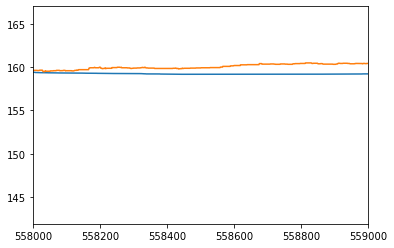

In [19]:
items_plot = test_data_y
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
#axes.set_ylim([145,170])
#axes.set_xlim([260000,261200])
#axes.set_xlim([100000,120000])
#axes.set_xlim([140000,160000])

axes.set_xlim([558000,559000])
#axes.set_xlim([610000,660000])
plt.show()